# Tarea M10 MPAD de González_Ramón

# Problema machine learning: Análisis jugadores similares mediante Clustering
**K-means para índices generales, seguido de KNN como técnica complementaria dentro del Clúster más relevante**

Mi elección por K-Means de debe a que es buena opción para este tipo de análisis por su simplicidad y efectividad. Es especialmente adecuado cuando se busca agrupar jugadores en clusters bien definidos basados en características similares.


### Template para Desarrollo de Modelos siguiendo CRISP-DM

In [1]:
### Configuración inicial, importación de bibliotecas

import numpy as np
import pandas as pd
import re
import unicodedata
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline   
from IPython.display import display, HTML

# Configuraciones
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Comprensión del Negocio


### <u>Objetivo del proyecto</u>

El objetivo de este proyecto es desarrollar un sistema de análisis de jugadores similares para comparar con los de la actual plantilla del Atlético de Madrid, y que permita identificar perfiles similares por una posible salida al mercado para sustituir o añadir a la plantilla. Esta herramienta será útil para la planificación de plantilla, detección de talentos y, como hemos dicho, posibles reemplazos en caso de lesiones o transferencias.

### <u>Contexto deportivo</u>

El fútbol moderno está cada vez más dominado por el análisis de datos. Esta es una fórmula en la que los equipos se pueden apoyar intentando buscar ventajas competitivas a través del uso inteligente de información estadística para la toma de decisiones. El Atlético de Madrid, como club de élite, necesita herramientas avanzadas para gestionar su plantilla y planificar el mercado de fichajes, que complementen otras vías para el conocimiento del posible jugador atlético.

### <u>Descripción del problema</u>

Se requiere un sistema que, mediante técnicas de machine learning, pueda:
- Agrupar jugadores según perfiles estadísticos similares (clustering);
- Dentro de los grupos formados, encontrar jugadores específicamente similares a los del Atlético de Madrid (KNN);
- Considerar diferentes métricas según la posición del jugador (porteros, defensas, centrocampistas, delanteros);
- Integrar datos de rendimiento deportivo con información de mercado, o métricas avanzadas (valor, contrato, etc.).

### <u>Criterios de éxito</u>

- Crear grupos de jugadores con sentido deportivo (clusters interpretables);
- Identificar jugadores similares a los actuales del Atlético de Madrid;
- Integrar correctamente métricas específicas por posición;
- Proporcionar recomendaciones útiles para departamento deportivo.

### <u>Recursos disponibles</u>

- Datos estadísticos de las 5 grandes ligas europeas (temporada 24/25), tanto de equipos, como de jugadores;
- Datos específicos para porteros de esas mismas ligas;
- Información de mercado de los jugadores (valor, contrato, etc.);
- Conocimiento previo sobre las necesidades del Atlético de Madrid;
- Archivos master para mapear posibles id, fotos, o cualquier recurso necesario.

# 2. Comprensión de los Datos

## 2.1 Carga de Datos

- Cargo solo columnas que entiendo voy a usar para no saturar de datos

In [2]:
def cargar_datos():
    """
    Carga los datasets necesarios para el análisis con selección optimizada de columnas
    """
    # Columnas para jugadores de campo
    columnas_general = [
        # Info básica
        'Jugador', 'Nacionalidad', 'Posicion', 'Equipo', 'Competicion', 
        'Edad', 'Nacimiento', 'Partidos', 'Titular', 'Minutos', '90s',
        
        # Estadísticas ofensivas
        'Goles', 'Asistencias', 'Goles+Asistencias', 'Disparos', 'Disparos_porteria', 
        'SoT%', 'G/Sh', 'G/SoT', 'xG', 'xG_sin_penal', 'G-xG', 'Tiros_falta', 'Penaltis',
        'PKattPer90', 'Regates_intentados', 'Regates_exitosos', 'DrbSucc%', 'DrbSucc%Per90',
        'Penal_provocado', 'GoalsPer90', 'ShotsPer90', 'SoTPer90', 'FKShotsPer90',         
        
        # Estadísticas de pases
        'Pases_completados', 'Pases_intentados', 'Pct_pases', 'Pases_clave', 'KeyPassesPer90',
        'Pases_ultimo_tercio', 'Pases_area', 'Pases_progresivos', 'ProgPassesPer90',
        'TotCmp%Per90', 'ShortPassCmp%Per90', 'MedPassCmp%Per90', 'LongPassCmp%Per90', 
        'Pases_ultimo_tercio', 'Pases_area', 'Pases_filtrados', 'Cambios_orientacion', 'ThruBallsPer90', 
        'Centros', 'Corners', 'SCA90', 'SCAPassDead', 'GCA90', 'GCAPassDead', 'GCA90Per90',
        'TouchesPer90', 'LiveTouchPer90', 'CarriesPer90', 'CarriesToFinalThirdPer90', 
        
        # Estadísticas defensivas
        'Entradas', 'Entradas_canadas', 'Def3rdTkl', 'Mid3rdTkl', 'Att3rdTkl',
        'Intercepciones', 'Entradas+Intercepciones', 'Despejes', 'Acc_defensivas_mas_disparo',
        'Bloqueos_cisparo', 'PassBlocks', 'Faltas_cometidas', 'Penal_cometido', 'Pct_duelos_aereos',  
        
        # Métricas ajustadas
        'pAdj_Entradas+Intercepciones_90min', 'pAdjClrPer90', 'pAdjDrbTklPer90',
        'pAdj_Intercepciones_90min', 'Centralidad_Toques', 'pAdjTklWinPossPer90',
        'pAdjAerialWinsPer90', 'pAdjDrbPastAttPer90', 'Tkl+IntPer600OppTouch',
        'pAdjTouchesPer90',
        
        # Estadísticas de posesión        
        'Conducciones', 'Conducciones_progresivas', 'CarriesToFinalThird', 'CarriesToPenArea',
        
        # Duelos
        'Duelos_aereos_ganados', 'Duelos_aereos_perdidos', 'Pct_duelos_aereos', 
        
        # Posición principal y secundaria para análisis más detallado
        'Posicion_princ', 'Posicion_2'
    ]
    
    # Columnas para porteros
    columnas_porteros = [
        # Info básica
        'Jugador', 'Nacionalidad', 'Posicion', 'Equipo', 'Competicion', 
        'Edad', 'Nacimiento', 'Partidos', 'Titular', 'Minutos', '90s',
        
        # Estadísticas defensivas
        'Goles_recibidos', 'Goles_recibidos_90min', 'Disparos_recibidos_porteria',
        'Paradas', 'Pct_paradas', 'Porterías_cero', 'CS%',
        
        # Estadísticas avanzadas
        'PSxG', 'PSxG/SoT', 'PSxG+/-', 'PSxG+/- /90', 'Centralidad_Toques', 'pAdjTouchesPer90', 
        
        # Estadísticas de distribución
        'LaunchCmp', 'LaunchAtt', 'LaunchPassCmp%', 'AvgLen',
        'GoalKicksAtt', 'GoalKicksLaunch%', 
        
        # Estadísticas de salidas
        'CrsStp%', 'Acciones_fuera_area', '#OPA/90', 'AvgDistOPA', 'pAdjAerialWinsPer90',
        
        # Estadísticas de penaltis
        'PKsFaced', 'PKA', 'PKsv', 'PKm'
    ]
    
    # Columnas para estadísticas de equipos
    columnas_equipos = [
        # Información básica del equipo
        'Equipo', 'Competicion', 'Jugadores', 'Media_edad', 'Posesion',
        
        # Partidos y resultados
        'Partidos_disputados', 'Min', '90s', 'W', 'D', 'L',
        
        # Estadísticas ofensivas
        'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'xG', 'npxG', 'xAG',
        'SCA', 'SCA90', 'GCA', 'GCA90',
        
        # Estadísticas de pases
        'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'PrgP', 'KP', 'PPA', 'CrsPA',
        
        # Estadísticas defensivas
        'GA', 'GA90', 'SoTA', 'Saves', 'Save%', 'CS', 'CS%',
        'Tkl', 'TklW', 'Int', 'Tkl+Int', 'Clr', 'Err',
        
        # Estadísticas de tarjetas
        'CrdY', 'CrdR', '2CrdY',
        
        # Estadísticas de posesión
        'Touches', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen',
        'Carries', 'PrgC', 'CPA', 'Succ', 'Succ%',
        
        # Duelos
        'Won', 'Lost', 'Won%'
    ]
    
    # Columnas para jugadores del Atlético
    columnas_atletico = [
        "nombre_completo", "short_name", "dorsal", "posicion", 
        "pais", "fecha_nacimiento", "ruta_foto"
    ]

    # Columnas para jugadores del Atlético
    columnas_master = [
        "short_name", "teamName", "nombre_oficial", "nombre_transfermarkt", "competicion" 
    ]
    
    try:
        # Cargar datos con columnas seleccionadas
        df_general = pd.read_csv('data/stats_players/stats_big5_24_25.csv', usecols=columnas_general)
        df_porteros = pd.read_csv('data/stats_players/stats_big5_gk_24_25.csv', usecols=columnas_porteros)
        df_equipos = pd.read_csv('data/stats_players/equipos_big5_stats_24_25.csv', usecols=columnas_equipos)
        df_atletico = pd.read_csv('data/master/jugadores_master.csv', sep=';', usecols=columnas_atletico)
        df_master_equipos = pd.read_csv('data/master/equipos_big5_master.csv', sep=';', usecols=columnas_master)

        # Estos los cargamos completos
        df_mercado = pd.read_csv('data/stats_players/knn_players.csv')
        
        
        print("Datos cargados correctamente con selección optimizada de columnas")
        return df_general, df_porteros, df_mercado, df_atletico, df_equipos, df_master_equipos
    except Exception as e:
        print(f"Error al cargar los datos: {e}")
        
        # Intentar cargar sin selección de columnas en caso de error
        print("Intentando cargar datos sin filtrar columnas...")
        try:
            df_general = pd.read_csv('data/stats_players/stats_big5_24_25.csv')
            df_porteros = pd.read_csv('data/stats_players/stats_big5_gk_24_25.csv')
            df_equipos = pd.read_csv('data/stats_players/equipos_big5_stats_24_25.csv')
            df_atletico = pd.read_csv('data/master/jugadores_master.csv', sep=';')
            df_mercado = pd.read_csv('data/stats_players/knn_players.csv')
            df_master_equipos = pd.read_csv('data/master/equipos_big5_master.csv', sep=';')
            
            print("Datos cargados sin optimización de columnas")
            return df_general, df_porteros, df_mercado, df_atletico, df_equipos, df_master_equipos
        except Exception as e2:
            print(f"Error al cargar datos sin filtrar: {e2}")
            # Crear DataFrames vacíos en caso de fallar todo
            return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Cargar datos
df_general, df_porteros, df_mercado, df_atletico, df_equipos, df_master_equipos = cargar_datos()

Datos cargados correctamente con selección optimizada de columnas


- Head de ejemplo

In [3]:
df_master_equipos.head()

,short_name,teamName,nombre_oficial,nombre_transfermarkt,competicion
0,ATH,Athletic Club,Athletic Club de Bilbao,athletic-club,LaLiga
1,ATM,Atletico,Club Atletico de Madrid,atletico-madrid,LaLiga
2,FCB,Barcelona,Futbol Club Barcelona,fc-barcelona,LaLiga
3,CEL,Celta Vigo,RC Celta de Vigo,celta-vigo,LaLiga
4,LEG,Leganes,CD Leganes,cd-leganes,LaLiga


## 2.2 Análisis Exploratorio


#### Explicación función exploratoria

Esta función de análisis exploratorio, además de incluir a los 6 DF's generados en el apartado anterior, realiza análisis específicos para diferentes tipos de datos y tiene una verificación de valores duplicados. Consta de:

- Mejor formato para los encabezados;

- Análisis más detallado de valores faltantes con porcentajes;

- Detección de filas duplicadas;

- Estadísticas descriptivas resaltadas para identificar fácilmente máximos y mínimos;

- Análisis de columnas categóricas con conteos de valores;

- Inclusión de todos los datasets que he cargado.

In [4]:
def analisis_exploratorio(df, title="Dataset"):
    """
    Realizar análisis exploratorio inicial
    """
    print(f"\n{'-'*50}")
    print(f" Análisis de {title} ".center(50, '='))
    print(f"{'-'*50}")
    
    # Info básica
    print(f"\nDimensiones del Dataset: {df.shape[0]} filas x {df.shape[1]} columnas")

    # Información de columnas y tipos de datos
    print("\nInformación de columnas:")
    print(df.info(memory_usage='deep', verbose=False))
    
    # Muestra de primeras filas
    print("\nPrimeras filas:")
    display(df.head(3))
    
    # Tipología de datos
    print("\nTipos de datos (resumen):")
    print(df.dtypes.value_counts())
    
    # Valores faltantes (resumen)
    missing_count = df.isnull().sum().sum()
    missing_percent = (missing_count / (df.shape[0] * df.shape[1])) * 100
    print(f"\nValores faltantes: {missing_count} ({missing_percent:.2f}% del total)")
    
    # Si hay valores faltantes, mostrar top 5 columnas con más faltantes
    if missing_count > 0:
        top_missing = df.isnull().sum().sort_values(ascending=False).head(5)
        print("Top 5 columnas con más valores faltantes:")
        for col, count in top_missing.items():
            if count > 0:
                print(f"  - {col}: {count} ({count/len(df)*100:.1f}%)")
    
    # Valores duplicados
    duplicates = df.duplicated().sum()
    print(f"\nFilas duplicadas: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    # Estadísticas numéricas (resumen)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print(f"\nColumnas numéricas: {len(numeric_cols)}")
        # Mostrar estadísticas para una pequeña muestra de columnas numéricas
        sample_cols = numeric_cols[:3] if len(numeric_cols) > 3 else numeric_cols
        if sample_cols.any():
            print("Muestra de estadísticas (primeras 3 columnas numéricas):")
            display(df[sample_cols].describe().T)

    # Info de columnas categóricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print(f"\nColumnas categóricas: {len(categorical_cols)}")
        # Mostrar valores únicos para una pequeña muestra
        sample_cat_cols = categorical_cols[:3] if len(categorical_cols) > 3 else categorical_cols
        for col in sample_cat_cols:
            unique_count = df[col].nunique()
            print(f"  - {col}: {unique_count} valores únicos")
    
    return None

# Análisis de los datasets
datasets = [
    (df_general, "Jugadores de Campo"),
    (df_porteros, "Porteros"),
    (df_mercado, "Datos de Mercado"),
    (df_atletico, "Jugadores del Atlético de Madrid"),
    (df_equipos, "Estadísticas de Equipos"),
    (df_master_equipos, "Master Equipos Big 5")
]

for df, title in datasets:
    if not df.empty:
        analisis_exploratorio(df, title)


--------------------------------------------------
========= Análisis de Jugadores de Campo =========
--------------------------------------------------

Dimensiones del Dataset: 2568 filas x 93 columnas

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568 entries, 0 to 2567
Columns: 93 entries, Jugador to Posicion_2
dtypes: float64(41), int64(45), object(7)
memory usage: 2.7 MB
None

Primeras filas:


,Jugador,Nacionalidad,Posicion,Equipo,Competicion,Edad,Nacimiento,Partidos,Titular,Minutos,Goles+Asistencias,Goles,Disparos,Disparos_porteria,SoT%,G/Sh,G/SoT,Tiros_falta,Penaltis,xG,xG_sin_penal,G-xG,Pases_completados,Pases_intentados,Pct_pases,Asistencias,Pases_clave,Pases_ultimo_tercio,Pases_area,Pases_progresivos,Pases_filtrados,Cambios_orientacion,Centros,Corners,SCA90,SCAPassDead,Acc_defensivas_mas_disparo,GCA90,GCAPassDead,Entradas,Entradas_canadas,Def3rdTkl,Mid3rdTkl,Att3rdTkl,Bloqueos_cisparo,PassBlocks,Intercepciones,Entradas+Intercepciones,Despejes,Regates_intentados,Regates_exitosos,DrbSucc%,Conducciones,Conducciones_progresivas,CarriesToFinalThird,CarriesToPenArea,Faltas_cometidas,Penal_provocado,Penal_cometido,Duelos_aereos_ganados,Duelos_aereos_perdidos,Pct_duelos_aereos,90s,GoalsPer90,ShotsPer90,SoTPer90,FKShotsPer90,PKattPer90,TotCmp%Per90,ShortPassCmp%Per90,MedPassCmp%Per90,LongPassCmp%Per90,KeyPassesPer90,ProgPassesPer90,ThruBallsPer90,GCA90Per90,TouchesPer90,LiveTouchPer90,DrbSucc%Per90,CarriesPer90,CarriesToFinalThirdPer90,pAdj_Entradas+Intercepciones_90min,pAdjClrPer90,pAdj_Intercepciones_90min,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjAerialWinsPer90,pAdjDrbPastAttPer90,Centralidad_Toques,Tkl+IntPer600OppTouch,pAdjTouchesPer90,Posicion_princ,Posicion_2
0,Aaron Ciammaglichella,ITA,MF,Torino,Serie A,20,2005,1,0,1.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.01,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,MF,MF
1,Aaron Cresswell,ENG,DF,West Ham,Premier League,35,1989,13,6,544.0,0,0,3,0,0.0,0.0,0.0,2,0,0.1,0.1,-0.1,320,402,79.6,0,7,38,4,23,1,4,26,9,1.99,7,0,0.0,0,5,1,1,3,1,3,3,6,11,26,1,1,100.0,180,4,7,0,1,0,0,7,6,53.8,6.04,0.0,0.5,0.0,0.33,0.0,13.17,14.81,14.1,9.22,1.16,3.81,0.17,0.0,74.45,74.45,16.54,29.78,1.16,1.72,4.06,0.94,0.62,0.62,1.09,0.78,12.69,1.71,79.2,Left-Back,Left-Back
2,Aaron Malouda,FRA,FW,Lille,Ligue 1,19,2005,1,0,2.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,45.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,FW,FW



Tipos de datos (resumen):
int64      45
float64    41
object      7
Name: count, dtype: int64

Valores faltantes: 0 (0.00% del total)

Filas duplicadas: 0 (0.00%)

Columnas numéricas: 86
Muestra de estadísticas (primeras 3 columnas numéricas):


,count,mean,std,min,25%,50%,75%,max
Edad,2568.0,25.555685,4.356710,16.0,22.0,25.0,28.0,41.0
Nacimiento,2568.0,1998.760903,4.354437,1983.0,1996.0,1999.0,2002.0,2008.0
Partidos,2568.0,15.360592,8.911286,1.0,7.0,17.0,23.0,30.0



Columnas categóricas: 7
  - Jugador: 2423 valores únicos
  - Nacionalidad: 111 valores únicos
  - Posicion: 3 valores únicos

--------------------------------------------------
============== Análisis de Porteros ==============
--------------------------------------------------

Dimensiones del Dataset: 195 filas x 39 columnas

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Columns: 39 entries, Jugador to pAdjTouchesPer90
dtypes: float64(30), int64(4), object(5)
memory usage: 106.5 KB
None

Primeras filas:


,Jugador,Nacionalidad,Posicion,Equipo,Competicion,Edad,Nacimiento,Partidos,Titular,Minutos,Goles_recibidos,Goles_recibidos_90min,Disparos_recibidos_porteria,Paradas,Pct_paradas,Porterías_cero,CS%,PKsFaced,PKA,PKsv,PKm,PSxG,PSxG/SoT,PSxG+/-,PSxG+/- /90,LaunchCmp,LaunchAtt,LaunchPassCmp%,GoalKicksAtt,GoalKicksLaunch%,AvgLen,CrsStp%,Acciones_fuera_area,#OPA/90,AvgDistOPA,90s,pAdjAerialWinsPer90,Centralidad_Toques,pAdjTouchesPer90
0,Aaron Ramsdale,ENG,GK,Southampton,Premier League,26,1998,21,21,1890.0,50.0,2.38,139.0,89.0,66.9,2.0,9.5,4.0,4.0,0.0,0.0,46.2,0.32,-3.8,-0.18,134.0,413.0,32.4,120.0,75.0,54.2,6.3,15.0,0.71,12.6,21.00,0.19,7.31,44.78
1,Adrian Rodriguez,ESP,GK,Alaves,La Liga,24,2000,2,1,122.0,2.0,1.48,6.0,4.0,83.3,1.0,100.0,1.0,1.0,0.0,0.0,1.5,0.13,-0.5,-0.36,18.0,48.0,37.5,24.0,100.0,67.4,0.0,0.0,0.00,9.8,1.36,0.00,8.56,46.92
2,Adrián,ESP,GK,Betis,La Liga,38,1987,10,10,900.0,13.0,1.30,31.0,18.0,61.3,3.0,30.0,1.0,1.0,0.0,0.0,11.0,0.33,-2.0,-0.20,31.0,94.0,33.0,46.0,37.0,36.6,5.0,6.0,0.60,12.6,10.00,0.10,5.42,32.41



Tipos de datos (resumen):
float64    30
object      5
int64       4
Name: count, dtype: int64

Valores faltantes: 0 (0.00% del total)

Filas duplicadas: 0 (0.00%)

Columnas numéricas: 34
Muestra de estadísticas (primeras 3 columnas numéricas):


,count,mean,std,min,25%,50%,75%,max
Edad,195.0,28.835897,4.631108,18.0,25.0,28.0,32.0,42.0
Nacimiento,195.0,1995.476923,4.556997,1982.0,1992.0,1996.0,1999.0,2006.0
Partidos,195.0,14.138462,10.253805,1.0,5.0,12.0,24.5,30.0



Columnas categóricas: 5
  - Jugador: 192 valores únicos
  - Nacionalidad: 49 valores únicos
  - Posicion: 1 valores únicos

--------------------------------------------------
========== Análisis de Datos de Mercado ==========
--------------------------------------------------

Dimensiones del Dataset: 2580 filas x 7 columnas

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Columns: 7 entries, dorsal to equipo
dtypes: object(7)
memory usage: 1.1 MB
None

Primeras filas:


,dorsal,nombre,Altura,Pie,fin_contrato,valor_mercado,equipo
0,1,Thibaut Courtois,"2,00m",Izquierdo,30/06/2026,"25,00 mill. €",real-madrid
1,13,Andriy Lunin,"1,91m",Derecho,30/06/2030,"20,00 mill. €",real-madrid
2,3,Éder Militão,"1,86m",Derecho,30/06/2028,"40,00 mill. €",real-madrid



Tipos de datos (resumen):
object    7
Name: count, dtype: int64

Valores faltantes: 25 (0.14% del total)
Top 5 columnas con más valores faltantes:
  - Pie: 25 (1.0%)

Filas duplicadas: 0 (0.00%)

Columnas categóricas: 7
  - dorsal: 94 valores únicos
  - nombre: 2576 valores únicos
  - Altura: 44 valores únicos

--------------------------------------------------
== Análisis de Jugadores del Atlético de Madrid ==
--------------------------------------------------

Dimensiones del Dataset: 32 filas x 7 columnas

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Columns: 7 entries, nombre_completo to ruta_foto
dtypes: int64(1), object(6)
memory usage: 11.9 KB
None

Primeras filas:


,nombre_completo,short_name,dorsal,posicion,pais,fecha_nacimiento,ruta_foto
0,Juan Musso,Musso,1,GK,Argentina,06/05/1994,assets/players/1.png'
1,Jose María Giménez,Giménez,2,DF,Uruguay,20/01/1995,assets/players/2.png'
2,César Azpilicueta,Azpilcueta,3,DF,España,28/08/1989,assets/players/3.png'



Tipos de datos (resumen):
object    6
int64     1
Name: count, dtype: int64

Valores faltantes: 0 (0.00% del total)

Filas duplicadas: 0 (0.00%)

Columnas numéricas: 1
Muestra de estadísticas (primeras 3 columnas numéricas):


,count,mean,std,min,25%,50%,75%,max
dorsal,32.0,18.3125,11.91756,1.0,8.75,16.5,27.25,43.0



Columnas categóricas: 6
  - nombre_completo: 32 valores únicos
  - short_name: 32 valores únicos
  - posicion: 4 valores únicos

--------------------------------------------------
====== Análisis de Estadísticas de Equipos =======
--------------------------------------------------

Dimensiones del Dataset: 96 filas x 62 columnas

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Columns: 62 entries, Equipo to Won%
dtypes: float64(14), int64(46), object(2)
memory usage: 56.1 KB
None

Primeras filas:


,Equipo,Competicion,Jugadores,Media_edad,Posesion,Partidos_disputados,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,PrgC,PrgP,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,Cmp,Att,Cmp%,TotDist,PrgDist,KP,PPA,CrsPA,SCA,SCA90,GCA,GCA90,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Lost,Int,Tkl+Int,Clr,Err,Touches,Att Pen,Succ,Succ%,Carries,CPA,2CrdY,Won,Won%
0,Alavés,La Liga,29,27.2,45.3,30,2700,30.0,33,18,51,27,6,8,85,4,34.7,28.4,20.7,370,906,44,1.47,113,70,70.8,7,9,14,5,16.7,287,683,42.0,157061,67149,225,179,82,551,18.37,53,1.77,556,349,276,220,60,282,252,808,699,9,14909,560,151,38.9,7174,79,2,515,48.9
1,Angers,Ligue 1,25,28.4,41.6,28,2520,28.0,25,14,39,20,5,6,39,2,31.2,26.5,21.3,416,794,46,1.64,165,119,73.9,7,6,15,5,17.9,124,363,34.2,160417,61230,183,170,56,453,16.18,45,1.61,518,331,285,164,69,252,286,804,741,16,14902,431,222,41.8,7853,86,0,282,44.6
2,Arsenal,eng Premier League,24,26.5,56.1,31,2790,31.0,54,43,97,52,2,2,62,5,48.5,47.0,37.0,686,1487,26,0.84,100,74,77.0,17,11,3,11,35.5,125,390,32.1,222487,70741,337,343,61,769,24.81,95,3.06,504,295,189,214,101,214,187,691,547,23,19339,1033,264,43.1,11223,231,2,407,51.3



Tipos de datos (resumen):
int64      46
float64    14
object      2
Name: count, dtype: int64

Valores faltantes: 0 (0.00% del total)

Filas duplicadas: 0 (0.00%)

Columnas numéricas: 60
Muestra de estadísticas (primeras 3 columnas numéricas):


,count,mean,std,min,25%,50%,75%,max
Jugadores,96.0,28.90625,3.350029,23.0,26.000,28.5,31.000,38.0
Media_edad,96.0,27.10000,1.284974,22.1,26.275,27.3,27.900,30.1
Posesion,96.0,49.97500,6.667991,37.9,45.125,49.4,54.375,68.9



Columnas categóricas: 2
  - Equipo: 96 valores únicos
  - Competicion: 5 valores únicos

--------------------------------------------------
======== Análisis de Master Equipos Big 5 ========
--------------------------------------------------

Dimensiones del Dataset: 96 filas x 5 columnas

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Columns: 5 entries, short_name to competicion
dtypes: object(5)
memory usage: 27.3 KB
None

Primeras filas:


,short_name,teamName,nombre_oficial,nombre_transfermarkt,competicion
0,ATH,Athletic Club,Athletic Club de Bilbao,athletic-club,LaLiga
1,ATM,Atletico,Club Atletico de Madrid,atletico-madrid,LaLiga
2,FCB,Barcelona,Futbol Club Barcelona,fc-barcelona,LaLiga



Tipos de datos (resumen):
object    5
Name: count, dtype: int64

Valores faltantes: 0 (0.00% del total)

Filas duplicadas: 0 (0.00%)

Columnas categóricas: 5
  - short_name: 94 valores únicos
  - teamName: 96 valores únicos
  - nombre_oficial: 96 valores únicos


### <u>Primeras conclusiones</u>

La exploración de datos que se ha realizado es buena, aunque con mucha información. Los aspectos más relevantes que podemos extraer:

1. Jugadores de Campo (2568 jugadores):
- 93 columnas con mayoría numéricas (86 columnas);
- No hay valores faltantes ni duplicados;
- Datos de 2423 jugadores únicos (algunos aparecen con variantes de nombre, al cambiar de equipo);
- 111 nacionalidades diferentes;
- 3 posiciones generales (DF, MF, FW).

2. Porteros (195 jugadores):
- 39 columnas, mayormente numéricas (34);
- No hay valores faltantes ni duplicados;
- 192 porteros únicos;
- 49 nacionalidades diferentes;
- Todos tienen "Posicion: GK".

3. Datos de Mercado (2580 registros):
- 7 columnas, todas categóricas;
- 25 valores faltantes en la columna "Pie" (1%);
- 2576 jugadores únicos;
- 44 valores distintos de altura;
- Incluye dorsal y equipo.

4. Jugadores del Atlético (32 jugadores):
- 7 columnas (6 categóricas, 1 numérica);
- 32 jugadores únicos.

5. Estadísticas de Equipos (96 equipos):
- 62 columnas (60 numéricas);
- No hay valores faltantes;
- 96 equipos únicos de 5 competiciones.

6. Master Equipos Big 5 (96 equipos):
- 5 columnas (categóricas).

## 2.3 Visualizaciones Iniciales

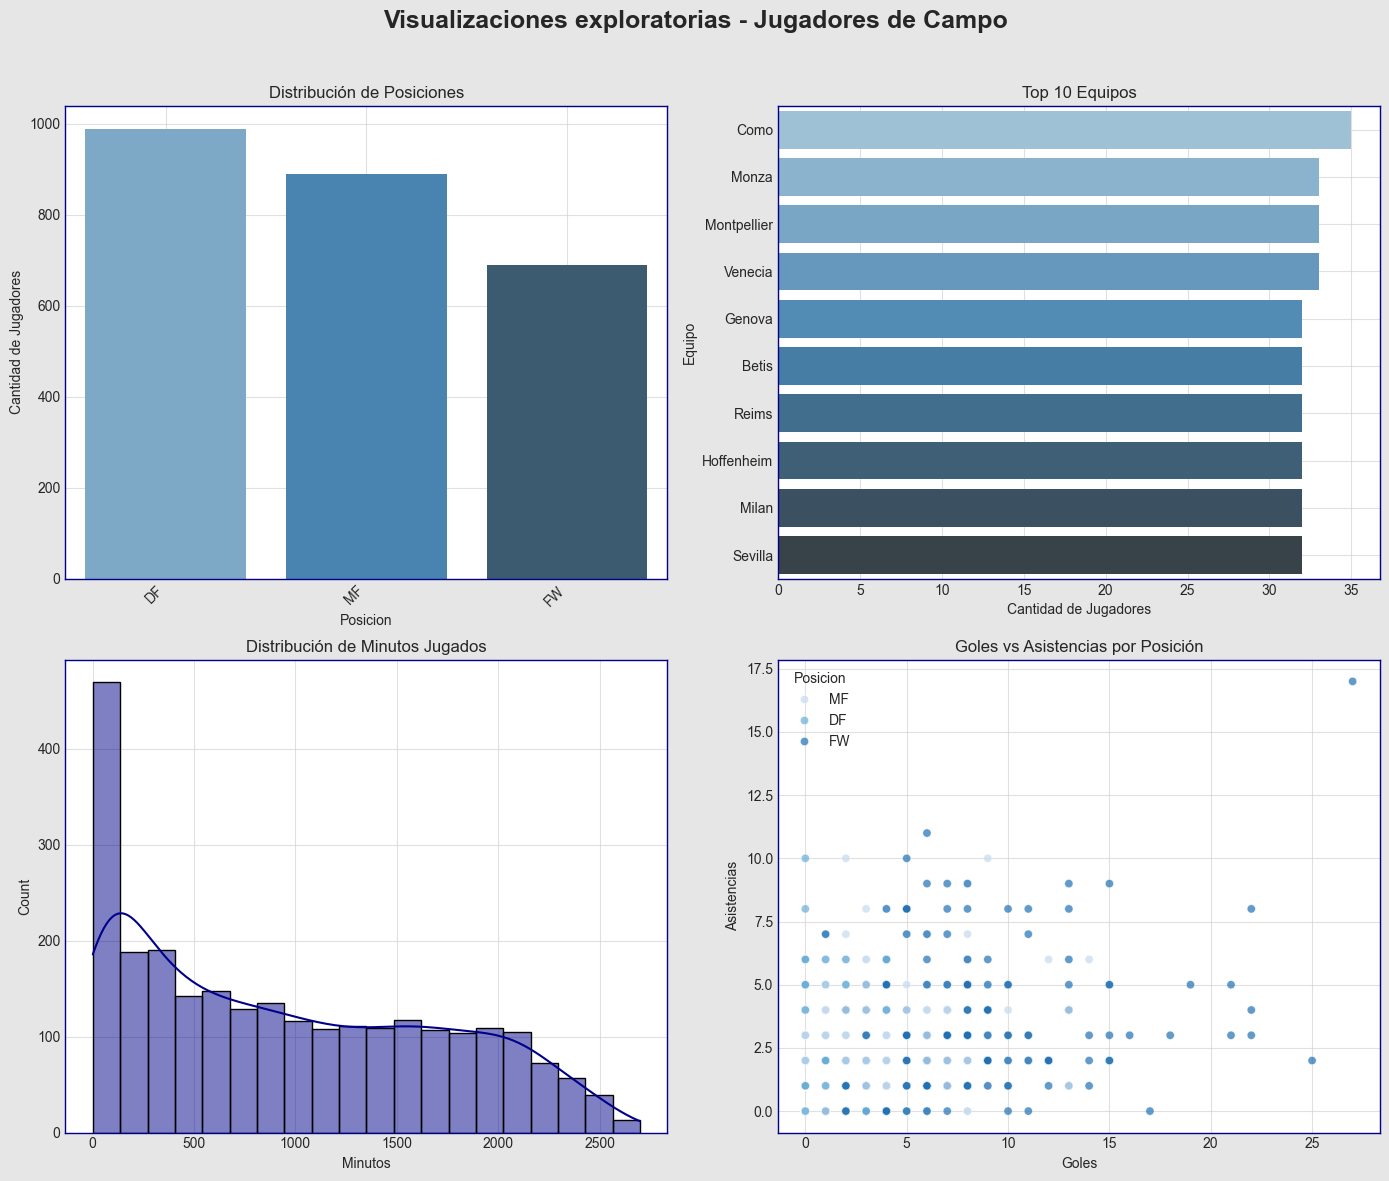

<Figure size 1200x1000 with 0 Axes>

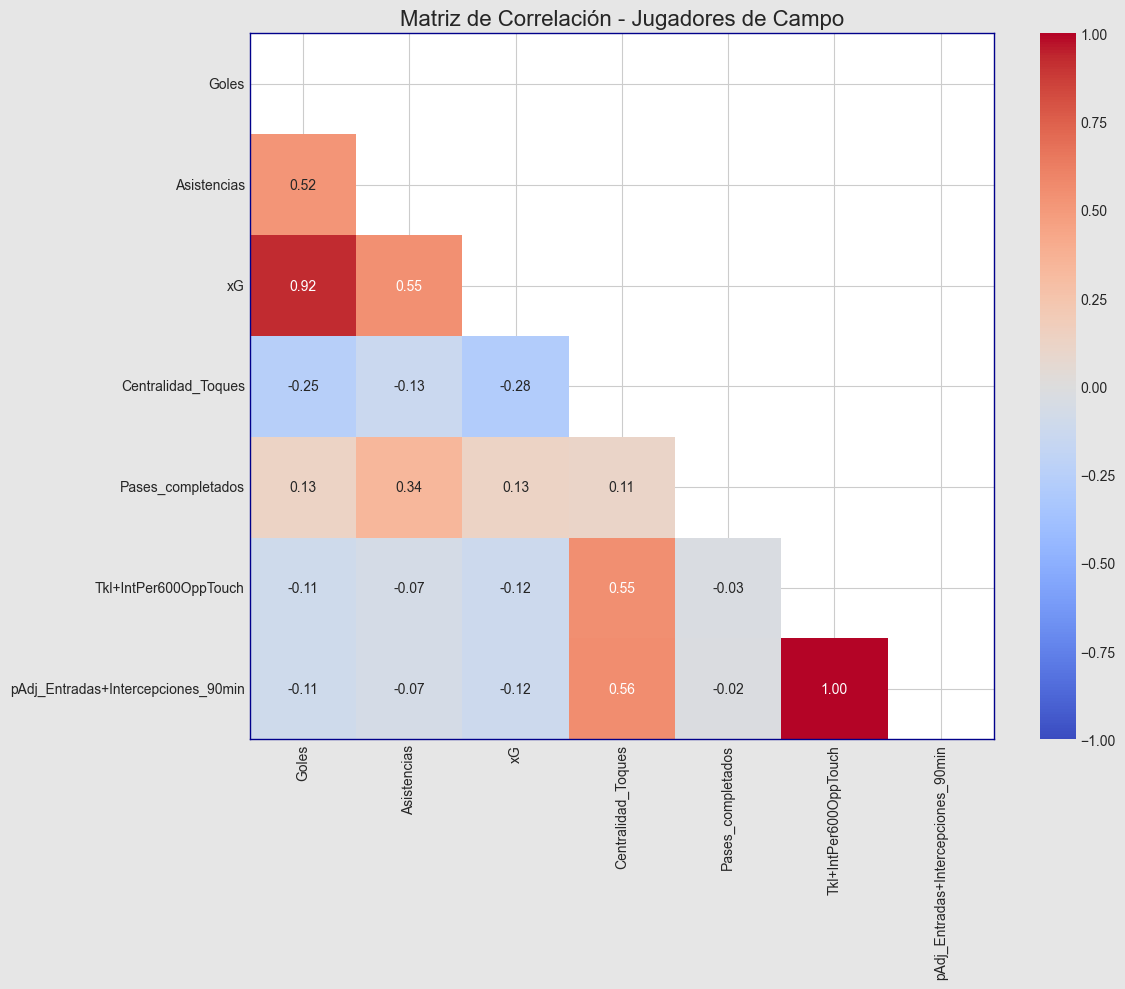

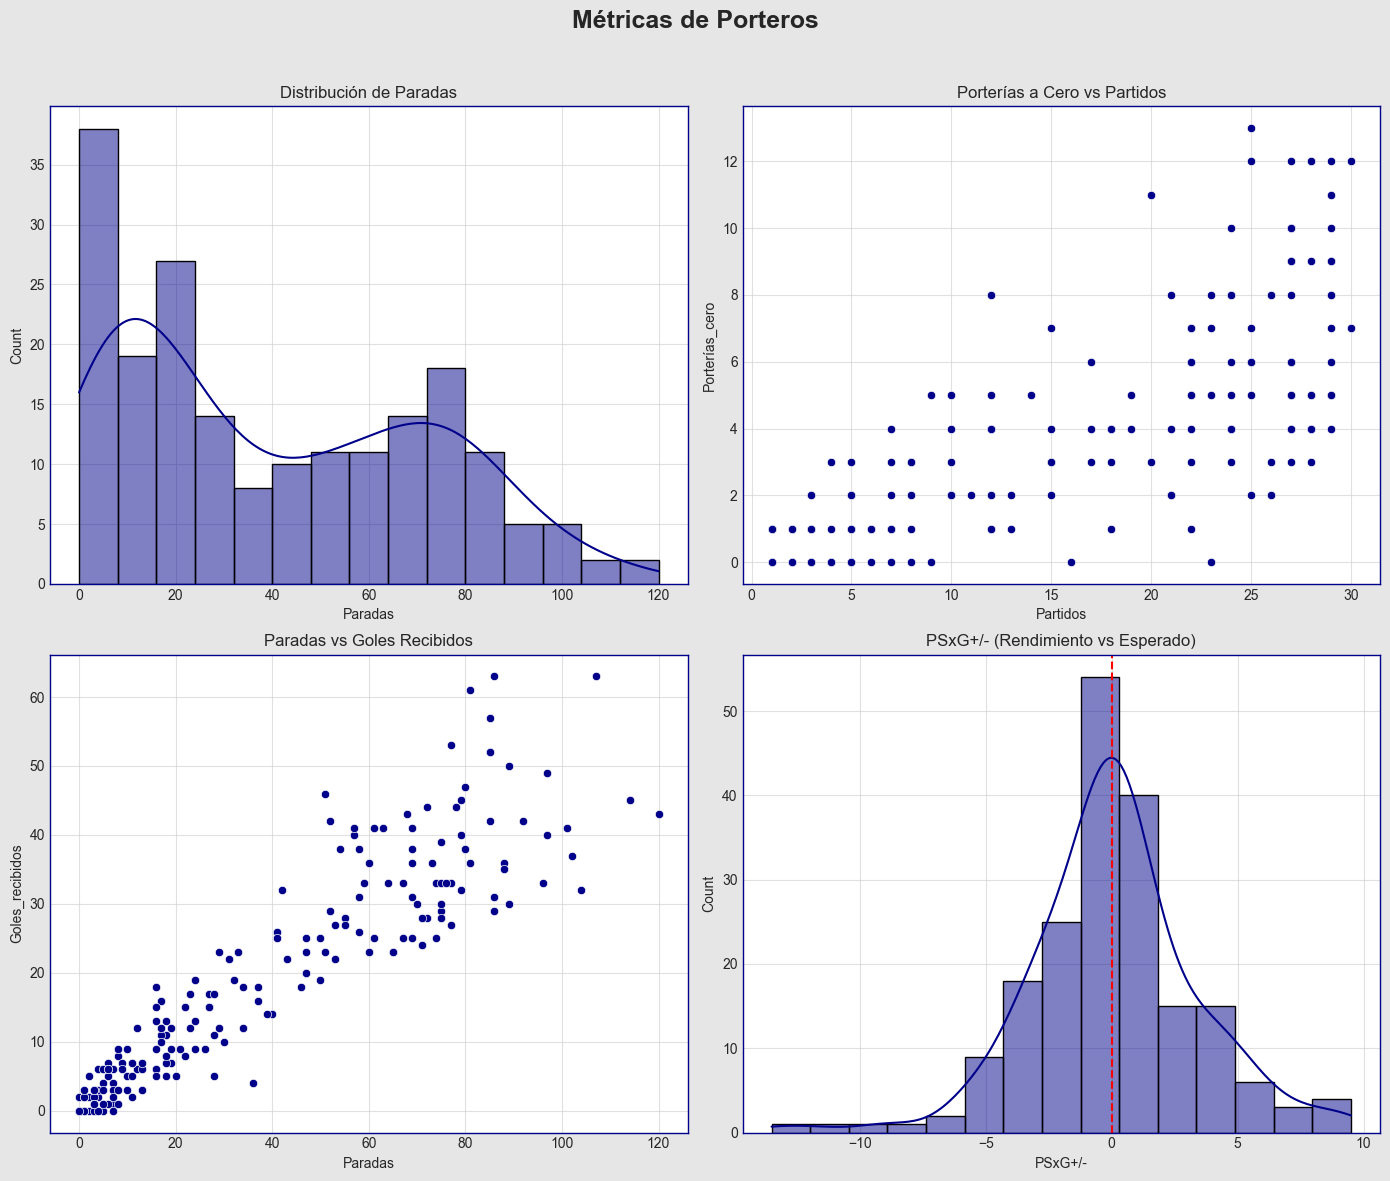

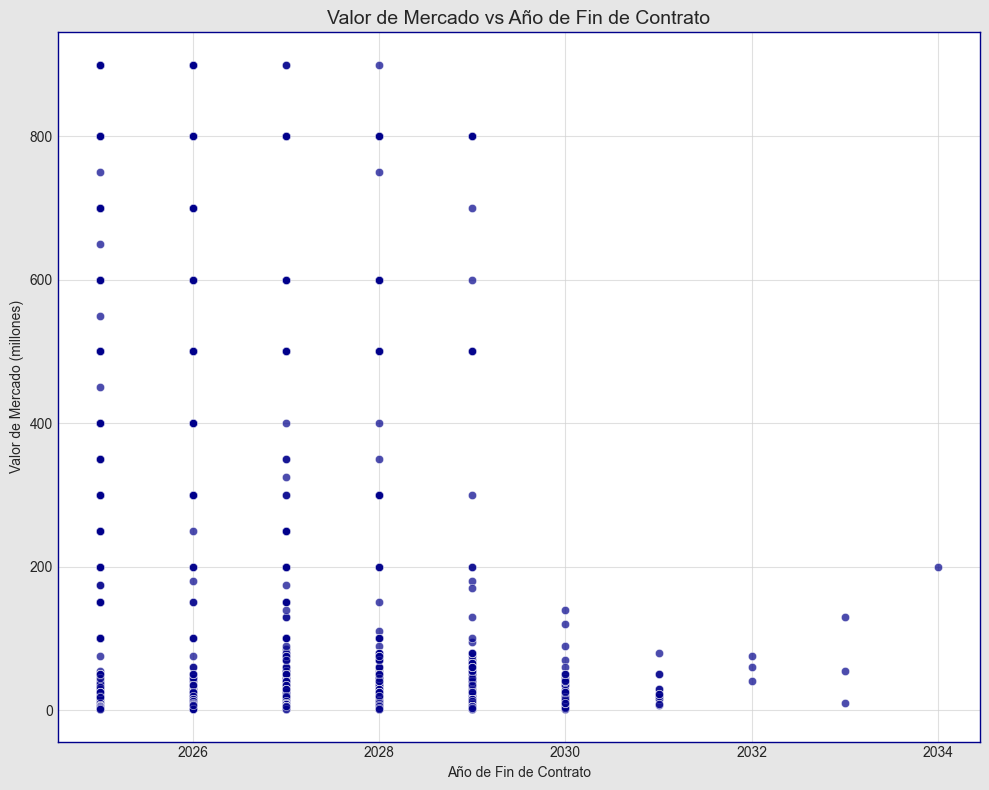

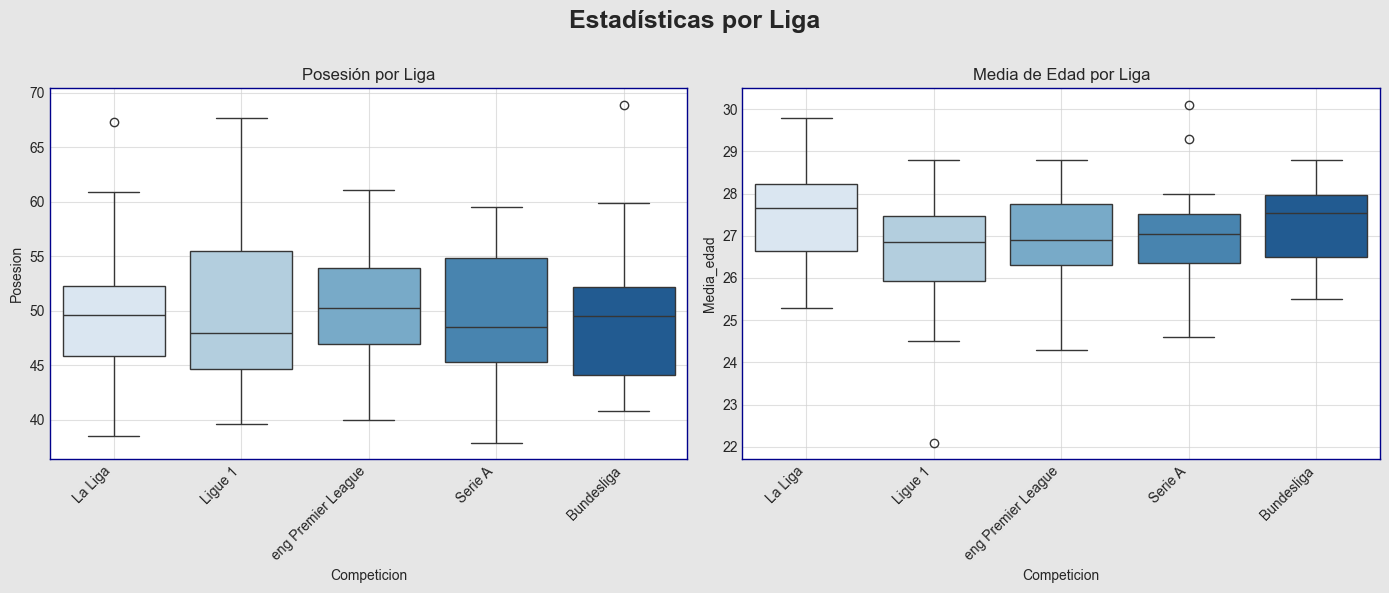

In [5]:
def visualizaciones_iniciales(df, title="Dataset"):
    """
    Crear visualizaciones exploratorias con estilo personalizado
    """
    # Configuración de estilo
    facecolor = "#E6E6E6"
    
    # JUGADORES DE CAMPO
    if title == "Jugadores de Campo":
        fig, axes = plt.subplots(2, 2, figsize=(14, 12), facecolor=facecolor)
        fig.suptitle(f'Visualizaciones exploratorias - {title}', fontsize=18, fontweight='bold')
        
        # 1. Distribución de posiciones
        ax1 = axes[0, 0]
        posiciones = df['Posicion'].value_counts()
        sns.barplot(x=posiciones.index, y=posiciones.values, ax=ax1, palette='Blues_d')
        ax1.set_title('Distribución de Posiciones')
        ax1.set_ylabel('Cantidad de Jugadores')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        
        # Aplicar estilo
        ax1.set_facecolor('white')
        for spine in ax1.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax1.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        
        # 2. Distribución de equipos (Top 10)
        ax2 = axes[0, 1]
        equipos = df['Equipo'].value_counts().head(10)
        sns.barplot(x=equipos.values, y=equipos.index, ax=ax2, palette='Blues_d')
        ax2.set_title('Top 10 Equipos')
        ax2.set_xlabel('Cantidad de Jugadores')
        
        # Estilo
        ax2.set_facecolor('white')
        for spine in ax2.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax2.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        
        # 3. Distribución de minutos jugados
        ax3 = axes[1, 0]
        sns.histplot(df['Minutos'], bins=20, kde=True, ax=ax3, color='darkblue')
        ax3.set_title('Distribución de Minutos Jugados')
        ax3.set_xlabel('Minutos')
        
        # Estilo
        ax3.set_facecolor('white')
        for spine in ax3.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax3.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        
        # 4. Goles vs asistencias
        ax4 = axes[1, 1]
        sns.scatterplot(x='Goles', y='Asistencias', hue='Posicion', data=df, ax=ax4, alpha=0.7, palette='Blues')
        ax4.set_title('Goles vs Asistencias por Posición')
        
        # Estilo
        ax4.set_facecolor('white')
        for spine in ax4.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax4.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        # Matriz de correlación para jugadores
        try:
            # Seleccionar columnas relevantes para matriz de correlación
            corr_cols = ['Goles', 'Asistencias', 'xG', 'Centralidad_Toques', 'Pases_completados', 
                        'Tkl+IntPer600OppTouch', 'ProgCarriesPer50Touches', 'pAdj_Entradas+Intercepciones_90min']
            corr_cols = [col for col in corr_cols if col in df.columns]
            
            if len(corr_cols) > 1:
                plt.figure(figsize=(12, 10), facecolor=facecolor)
                
                # Se crea eje y figura manualmente para mayor control
                fig, ax = plt.subplots(figsize=(12, 10), facecolor=facecolor)
                
                corr = df[corr_cols].corr()
                mask = np.triu(np.ones_like(corr))
                
                # Heatmap
                sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
                        mask=mask, vmin=-1, vmax=1, ax=ax)
                
                plt.title(f'Matriz de Correlación - {title}', fontsize=16)
                
                # Estilo después de Heatmap
                for spine in ax.spines.values():
                    spine.set_visible(True)  # Visibles los bordes
                    spine.set_color('darkblue')
                    spine.set_linewidth(1)  # Borde más grueso
                
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"No se pudo generar la matriz de correlación: {e}")
        
    # PORTEROS
    elif title == "Porteros":
        # Seleccionar métricas relevantes para porteros
        portero_cols = ['Paradas', 'Goles_recibidos', 'Porterías_cero', 'Pct_paradas', 
                        'CS%', 'PSxG+/-', 'pAdjTouchesPer90', 'Goles_recibidos_90min']
        portero_cols = [col for col in portero_cols if col in df.columns]
        
        if len(portero_cols) > 1:
            # Visualizaciones para métricas de porteros
            fig, axes = plt.subplots(2, 2, figsize=(14, 12), facecolor=facecolor)
            fig.suptitle(f'Métricas de {title}', fontsize=18, fontweight='bold')
            
            # 1. Distribución de paradas
            ax1 = axes[0, 0]
            if 'Paradas' in df.columns:
                sns.histplot(df['Paradas'], bins=15, kde=True, ax=ax1, color='darkblue')
                ax1.set_title('Distribución de Paradas')
            
            # Estilo
            ax1.set_facecolor('white')
            for spine in ax1.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax1.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # 2. Porterías a cero vs partidos
            ax2 = axes[0, 1]
            if 'Porterías_cero' in df.columns and 'Partidos' in df.columns:
                sns.scatterplot(x='Partidos', y='Porterías_cero', data=df, ax=ax2, color='darkblue')
                ax2.set_title('Porterías a Cero vs Partidos')
            
            # Estilo
            ax2.set_facecolor('white')
            for spine in ax2.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax2.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # 3. Paradas vs goles recibidos
            ax3 = axes[1, 0]
            if 'Paradas' in df.columns and 'Goles_recibidos' in df.columns:
                sns.scatterplot(x='Paradas', y='Goles_recibidos', data=df, ax=ax3, color='darkblue')
                ax3.set_title('Paradas vs Goles Recibidos')
            
            # Estilo
            ax3.set_facecolor('white')
            for spine in ax3.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax3.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # 4. PSxG+/- (Rendimiento vs Esperado)
            ax4 = axes[1, 1]
            if 'PSxG+/-' in df.columns:
                sns.histplot(df['PSxG+/-'], bins=15, kde=True, ax=ax4, color='darkblue')
                ax4.set_title('PSxG+/- (Rendimiento vs Esperado)')
                ax4.axvline(x=0, color='red', linestyle='--')
            
            # Estilo
            ax4.set_facecolor('white')
            for spine in ax4.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax4.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()
    
    # DATOS DE MERCADO
    elif title == "Datos de Mercado":
        plt.figure(figsize=(10, 8), facecolor=facecolor)
        ax = plt.subplot()
        
        try:
            # Procesar fin de contrato - extraer solo el año
            if 'fin_contrato' in df.columns:
                df['año_contrato'] = df['fin_contrato'].str.extract(r'(\d{4})').astype(float)
            
            # Procesar valor de mercado - extraer solo el número
            if 'valor_mercado' in df.columns:
                # Reemplazar comas por puntos y extraer el número
                df['valor_num'] = df['valor_mercado'].str.replace(',', '.').str.extract(r'(\d+[\.]*\d*)').astype(float)
            
            # Crear scatter plot si tenemos ambas columnas
            if 'año_contrato' in df.columns and 'valor_num' in df.columns:
                # Filtrar valores no nulos
                plot_df = df.dropna(subset=['año_contrato', 'valor_num'])
                
                if not plot_df.empty:
                    sns.scatterplot(x='año_contrato', y='valor_num', data=plot_df, alpha=0.7, color='darkblue')
                    plt.title('Valor de Mercado vs Año de Fin de Contrato', fontsize=14)
                    plt.xlabel('Año de Fin de Contrato')
                    plt.ylabel('Valor de Mercado (millones)')
                else:
                    plt.text(0.5, 0.5, "No hay datos válidos para visualizar", 
                            ha='center', va='center', fontsize=12)
            else:
                plt.text(0.5, 0.5, "Columnas necesarias no disponibles", 
                        ha='center', va='center', fontsize=12)
        except Exception as e:
            plt.text(0.5, 0.5, f"No se pudieron procesar los datos: {str(e)}", 
                    ha='center', va='center', fontsize=12)
        
        # Estilo
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    # ESTADÍSTICAS DE EQUIPOS
    elif title == "Estadísticas de Equipos":
        # Eliminar columnas duplicadas si existen
        # Identificamos si hay duplicados en nombres de columnas
        if len(df.columns) != len(set(df.columns)):
            # Crear un nuevo dataframe con columnas únicas
            df_clean = df.loc[:, ~df.columns.duplicated()]
            print(f"Se eliminaron {len(df.columns) - len(df_clean.columns)} columnas duplicadas")
        else:
            df_clean = df
            
        # Métricas relevantes
        team_cols = ['Equipo', 'Competicion', 'Media_edad', 'Posesion', 'Gls']
        
        # Alternativas si no existen las columnas exactas
        if 'Media_edad' not in df_clean.columns and 'Age' in df_clean.columns:
            df_clean['Media_edad'] = df_clean['Age']
        
        if 'Gls' not in df_clean.columns and 'Goles' in df_clean.columns:
            df_clean['Gls'] = df_clean['Goles']
        
        # Filtrar solo columnas que existen
        team_cols = [col for col in team_cols if col in df_clean.columns]
        
        if len(team_cols) >= 3:  # Se necesita al menos Equipo, Competicion y una métrica
            # Visualizaciones para estadísticas de equipos
            fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=facecolor)
            fig.suptitle(f'Estadísticas por Liga', fontsize=18, fontweight='bold')
            
            # 1. Posesión por liga
            ax1 = axes[0]
            if 'Posesion' in df_clean.columns and 'Competicion' in df_clean.columns:
                sns.boxplot(x='Competicion', y='Posesion', data=df_clean, ax=ax1, palette='Blues')
                ax1.set_title('Posesión por Liga')
                ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
            
            # Estilo
            ax1.set_facecolor('white')
            for spine in ax1.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax1.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # 2. Media de edad por liga
            ax2 = axes[1]
            if 'Media_edad' in df_clean.columns and 'Competicion' in df_clean.columns:
                sns.boxplot(x='Competicion', y='Media_edad', data=df_clean, ax=ax2, palette='Blues')
                ax2.set_title('Media de Edad por Liga')
                ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
            
            # Estilo
            ax2.set_facecolor('white')
            for spine in ax2.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax2.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
        else:
            print(f"No hay suficientes columnas relevantes para visualizar estadísticas de equipos")
            print(f"Columnas disponibles: {', '.join(df_clean.columns[:20])}...")
    
    return None

# Visualizaciones de los datasets principales
datasets_to_visualize = [
    (df_general, "Jugadores de Campo"),
    (df_porteros, "Porteros"),
    (df_mercado, "Datos de Mercado"),
    (df_equipos, "Estadísticas de Equipos")
]

for df, title in datasets_to_visualize:
    if not df.empty:
        try:
            visualizaciones_iniciales(df, title)
        except Exception as e:
            print(f"Error al visualizar {title}: {e}")

### <u>Análisis visualizaicones</u>

1. Jugadores de Campo:
- Hay casi 1000 defensas, 900 mediocampistas y 700 delanteros en el dataset, lo que muestra una distribución coherente con la realidad del fútbol (más defensas y mediocampistas que delanteros).
- La distribución de minutos jugados tiene una clara asimetría positiva, con muchos jugadores con pocos minutos y una larga cola de jugadores con más experiencia.
- El scatter plot de Goles vs Asistencias muestra una clara diferenciación por posición, con los delanteros destacando en goles, mientras que los mediocampistas tienen mayor equilibrio entre ambas métricas.
- En la matriz de correlación, destaca la altísima correlación entre Goles y xG (0.92), lo que sugiere que el modelo de goles esperados es muy preciso.

2. Porteros:
- La distribución de paradas muestra dos picos (bimodal), reflejando porteros titulares (más paradas) y suplentes/con menos minutos.
- Existe una correlación positiva clara entre paradas y goles recibidos, lógico, ya que más minutos implican más exposición a ambas situaciones.
- El PSxG+/- (rendimiento vs esperado) se distribuye normalmente alrededor de cero, lo que indica que la mayoría de porteros rinden cerca de lo esperado, con algunos destacados en ambos extremos.

3. Datos de Mercado:
- Los contratos de la mayoría de jugadores finalizan entre 2025-2030, con una concentración especial en 2026 y 2028.
- Los valores de mercado más altos (>400M) se concentran en jugadores con contratos hasta 2026-2028, lo que sugiere que los clubes buscan asegurar a sus estrellas con contratos de media duración.

4. Estadísticas por Liga:
- La Bundesliga tiene la menor variabilidad en posesión, mientras que Ligue 1 muestra mayor dispersión.
- La Serie A y La Liga tienen una posesión mediana similar, pero La Liga tiene casos extremos más altos.
- En cuanto a la edad media, la Bundesliga tiene los equipos más jóvenes, mientras que La Liga presenta equipos con mayor experiencia.

Estas visualizaciones nos dan una excelente base para entender los perfiles de jugadores y seleccionar las características más relevantes para el análisis de clustering. Particularmente interesante es cómo se diferencian claramente los perfiles por posición en el scatter de goles vs asistencias, anticipando que el clustering debería capturar naturalmente estos diferentes roles en el campo.

# 3. Preparación de Datos

## 3.1 Limpieza de Datos

### <u>Proceso</u>

1. df_general: 
- Eliminar tildes y caracteres de nombres;
- Minutos no tenerlo como float;
- Cambiar nombre a correcto de columnas "Entradas_canadas" y "Bloqueos_cisparo";
- Adecuar algunos nombres para mayor conocimiento rápido de la métrica.

2. df_porteros:
- Mismo proceso que en el anterior DataFrame.

3. df_equipos:
- Elminar tildes y caracteres en nombres;
- Quitar sufijo "en" en columna de competición de los equipos de la "Premier League";
- Renombrar algunas columnas.

4. df_atletico:
- Normalizar nombres también;
- Fecha de nacimiento se deja en Datetime, y se extrae año de nacimiento.

5. df_mercado:
- Caracteres y tildes de nombres;
- Adecuar valores de altura y valor de mercado;
- Fin de contrato extraemos año y los faltantes los rellenamos con el actual, 2025;
- Equipos, para cruzar, viene igual que en la columna de "Nombre_transfermarkt" del archivo master_equipos;
- Valores de mercado faltantes se rellena con la mediana de los valores;
- Y los faltantes para pie dominante, desconocido, aunque revisaré por si hay alguno conocido.

6. df_master_equipos:
- No es necesario cambiar nada.

In [6]:
def limpiar_datos(df_general, df_porteros, df_mercado, df_atletico, df_equipos, df_master_equipos):
    """
    Realizar limpieza de datos y preparación inicial directamente sobre los dataframes originales
    """
    # Crear copias de seguridad por si falla algo
    df_general_original = df_general.copy()
    df_porteros_original = df_porteros.copy()
    df_mercado_original = df_mercado.copy()
    df_atletico_original = df_atletico.copy()
    df_equipos_original = df_equipos.copy()
    df_master_equipos_original = df_master_equipos.copy()

    # Función para normalizar texto (quitar acentos y caracteres especiales)
    def normalizar_texto(texto):
        if isinstance(texto, str):
            texto_normalizado = unicodedata.normalize('NFKD', texto)
            texto_sin_acentos = ''.join([c for c in texto_normalizado if not unicodedata.combining(c)])
            return texto_sin_acentos
        return texto
    
    # ---- Limpieza de df_atletico ----
    if not df_atletico.empty:

        # Duplicados
        df_atletico.drop_duplicates(subset=['nombre_completo', 'dorsal'], inplace=True)

        # Normalizar nombres
        if 'nombre_completo' in df_atletico.columns:
            df_atletico['nombre_completo'] = df_atletico['nombre_completo'].apply(normalizar_texto)
        
        if 'short_name' in df_atletico.columns:
            df_atletico['short_name'] = df_atletico['short_name'].apply(normalizar_texto)
        
        # Convertir fecha de nacimiento a datetime
        if 'fecha_nacimiento' in df_atletico.columns:
            df_atletico['fecha_nacimiento'] = pd.to_datetime(
                df_atletico['fecha_nacimiento'], 
                format='%d/%m/%Y', 
                errors='coerce'
            )

            # Extraer solo el año
            df_atletico['fecha_nacimiento'] = df_atletico['fecha_nacimiento'].dt.year
        
        # Renombrar columnas con diccionario
        cambios_columnas = {
            'nombre_completo': 'Nombre',
            'short_name': 'Nombre_corto',
            'posicion': 'Posicion',
            'dorsal': 'Numero',
            'pais': 'Nacionalidad',
            'fecha_nacimiento': 'Nacimiento'
        }
        df_atletico.rename(columns=cambios_columnas, inplace=True)        
    
    # ---- Limpieza de df_mercado ----
    if not df_mercado.empty:

        # Duplicados
        df_mercado.drop_duplicates(subset=['nombre', 'dorsal', 'equipo'], inplace=True)

        # Normalizar nombres
        if 'nombre' in df_mercado.columns:
            df_mercado['nombre'] = df_mercado['nombre'].apply(normalizar_texto)
        
        # Altura
        if 'Altura' in df_mercado.columns:
            df_mercado['Altura'] = df_mercado['Altura'].str.replace('m', '', regex=False)
            df_mercado['Altura'] = df_mercado['Altura'].str.replace(',', '.', regex=False)
            df_mercado['Altura'] = df_mercado['Altura'].replace('-', np.nan)  # Reemplazar '-' por NaN
            df_mercado['Altura'] = df_mercado['Altura'].astype(float)
        
        # Fin de contrato - solo extraer año
        if 'fin_contrato' in df_mercado.columns:
            df_mercado['fin_contrato'] = df_mercado['fin_contrato'].str.extract(r'(\d{4})').astype(float)
            df_mercado['fin_contrato'] = df_mercado['fin_contrato'].fillna(2025)
            # Convertir a entero para eliminar decimales
            df_mercado['fin_contrato'] = df_mercado['fin_contrato'].astype(int)

        # Valor de mercado
        if 'valor_mercado' in df_mercado.columns:
            # Función para procesar cada valor individualmente
            def procesar_valor(valor_str):
                if pd.isna(valor_str):
                    return None
                    
                # Reemplazar coma por punto para manejar decimales
                valor_str = str(valor_str).replace(',', '.')
                
                # Extraer el número
                match = re.search(r'(\d+(?:\.\d+)?)', valor_str)
                if not match:
                    return None
                    
                valor = float(match.group(1))
                
                # Aplicar factor según la unidad
                if 'mill' in valor_str.lower():
                    return valor * 1000000
                elif 'mil' in valor_str.lower():
                    return valor * 1000
                else:
                    return valor
            
            # Aplicar la función a cada valor
            df_mercado['valor_mercado'] = df_mercado['valor_mercado'].apply(procesar_valor)
            
            # Rellenar valores faltantes
            df_mercado['valor_mercado'] = df_mercado['valor_mercado'].fillna(df_mercado['valor_mercado'].median())
                    
        # Asignar pie dominante a jugadores específicos
        if 'Pie' in df_mercado.columns:
            pie_conocidos = {
                'Juan Carlos': 'Derecho',
                'Alfon Gonzalez': 'Derecho',
                'Antonio Raillo': 'Derecho',
                'Adrian Pica': 'Izquierdo'
            }
            
            for nombre, pie in pie_conocidos.items():
                matches = df_mercado['nombre'].str.contains(nombre, case=False, na=False)
                if matches.any():
                    df_mercado.loc[matches, 'Pie'] = pie
                            
            # Valores faltantes en pie
            df_mercado['Pie'] = df_mercado['Pie'].fillna("Desconocido")
        
        # Renombrar columnas con diccionario
        cambios_columnas = {
            'dorsal': 'Numero',
            'nombre': 'Nombre',
            'fin_contrato': 'Contrato',
            'valor_mercado': 'Valor',
            'equipo': 'Equipo'
        }
        df_mercado.rename(columns=cambios_columnas, inplace=True)

        # Rellenar valores faltantes de Altura con 0
        if 'Altura' in df_mercado.columns:
            df_mercado['Altura'] = df_mercado['Altura'].fillna(0)

        # Asegurar que Contrato sea entero sin decimales
        if 'Contrato' in df_mercado.columns:
            df_mercado['Contrato'] = df_mercado['Contrato'].astype(int)

        # Eliminar columnas adicionales si existen
        if 'año_contrato' in df_mercado.columns:
            df_mercado.drop('año_contrato', axis=1, inplace=True)
            
        if 'valor_num' in df_mercado.columns:
            df_mercado.drop('valor_num', axis=1, inplace=True)       
    
    # ---- Limpieza de df_equipos ----
    if not df_equipos.empty:

        # Duplicados
        df_equipos.drop_duplicates(subset=['Equipo', 'Competicion'], inplace=True)

        # Normalizar nombres de equipos
        if 'Equipo' in df_equipos.columns:
            df_equipos['Equipo'] = df_equipos['Equipo'].apply(normalizar_texto)

        df_equipos['Equipo'] = df_equipos['Equipo'].str.upper()
        
        # Versión corregida para limpiar nombres de competiciones
        if 'Competicion' in df_equipos.columns:            
            
            # Usar un patrón más específico para detectar los prefijos
            df_equipos['Competicion'] = df_equipos['Competicion'].str.replace(r'^(eng|es|it|de|fr) ', '', regex=True)
            
        # Renombrar columnas con diccionario
        cambios_columnas = {
            'Jugadores': 'Num_jugadores',
            'PK': 'Penaltis',
            'PKatt': 'Penaltis_lanzados',
            'GA': 'Goles_en_contra',
            'GA90': 'Goles_en_contra_por_90',
            'SoTA': 'Tiros_recibidos',
            'Saves': 'Paradas',
            'Save%': 'Pocentaje_paradas',
            'CS': 'Porterias_a_cero',
            'CS%': 'Porcentaje_porterias.a_cero',
            'Cmp': 'Pases',
            'Att': 'Pases_int',
            'Cmp%': 'Porcentaje_pases',
            'TotDist': 'Dist_pases',
            'PrgDist': 'Dist_progr_pases',
            'KP': 'Pases_clave',
            'PPA': 'Pases_area_penal',
            'CrsPA': 'Centros_area',
            'Def 3rd': 'Acc_def_primer_tercio',
            'Mid 3rd': 'Acc_def_segun_tercio',
            'Att 3rd': 'Acc_def_ult_tercio',
            'Lost': 'Perdidas',
            'Att Pen': 'Conducc_hasta_area',
            'Succ': 'Regates_exit',
            'Succ%': 'Porcentaje_regates',
            'CPA': 'Conducciones_hasta_area',
            'Won': 'Duelos_ganados',
            'Won%': 'Porcentaje_duelos_ganados'
        }
        df_equipos.rename(columns=cambios_columnas, inplace=True)        
    
    # ---- Limpieza de df_master_equipos ----
    if not df_master_equipos.empty:
        # Duplicados
        df_master_equipos.drop_duplicates(inplace=True)

        # Renombrar columnas con diccionario
        cambios_columnas = {
            'short_name': 'Nombre_corto',
            'team_name': 'Nombre',
            'nombre_oficial': 'Nombre_oficial',
            'competicion': 'Competicion'
        }
        df_master_equipos.rename(columns=cambios_columnas, inplace=True)

    # ---- Limpieza de df_general ----
    if not df_general.empty:

        # Eliminar duplicados
        df_general.drop_duplicates(subset=['Jugador', 'Equipo'], inplace=True)

        # Normalizar nombres de jugadores
        if 'Jugador' in df_general.columns:
            df_general['Jugador'] = df_general['Jugador'].apply(normalizar_texto)

        # Renombrar columnas con diccionario
        cambios_columnas = {
            'Jugador': 'Nombre',
            'Entradas_canadas': 'Entradas_ganadas',
            'Bloqueos_cisparo': 'Bloqueos_disparos',
            'pAdj_Entradas+Intercepciones_90min': 'Acc_defensivas_por90_ajus_posesion',
            'pAdjClrPer90': 'Despejes_por90_ajus_posesion'
        }
        df_general.rename(columns=cambios_columnas, inplace=True)
        
        # Convertir Minutos a int
        if 'Minutos' in df_general.columns:
            df_general['Minutos'] = df_general['Minutos'].astype(int)
        
        # Manejo de valores faltantes para datos numéricos
        numeric_cols = df_general.select_dtypes(include=['float64', 'int64']).columns
        df_general[numeric_cols] = df_general.groupby('Posicion')[numeric_cols].transform(
            lambda x: x.fillna(x.median())
        )   

        # Eliminar columna de Posicion Principal porque más adelante me dará muchos problemas
        if 'Posicion_princ' in df_general.columns:
            df_general.drop('Posicion_princ', axis=1, inplace=True)    
    
    # ---- Limpieza de df_porteros ----
    if not df_porteros.empty:

        # Eliminar duplicados
        df_porteros.drop_duplicates(subset=['Jugador', 'Equipo'], inplace=True)

        # Normalizar nombres de porteros
        if 'Jugador' in df_porteros.columns:
            df_porteros['Jugador'] = df_porteros['Jugador'].apply(normalizar_texto)
        
        # Convertir Minutos a int
        if 'Minutos' in df_porteros.columns:
            df_porteros['Minutos'] = df_porteros['Minutos'].astype(int)
        
        # Manejo de valores faltantes para datos numéricos
        numeric_cols = df_porteros.select_dtypes(include=['float64', 'int64']).columns
        df_porteros[numeric_cols] = df_porteros[numeric_cols].fillna(df_porteros[numeric_cols].median())
        
        # Renombrar columnas con diccionario
        cambios_columnas = {
            'Jugador': 'Nombre',
            'CS%': 'Porcentajes_porterias_a_cero',
            'PKsFaced': 'Penaltis_recibidos',
            'PKsv': 'Penaltis_parados',
            'PKA':  'Penaltis_encajados',
            'PKm': 'Penaltis_errados_por_rival',
            'PSxG': 'xG_tras_tiro',
            'PSxG/SoT': 'PSxG_por_disparos_a_puerta', # Valor alto, mejor cualidad
            'PSxG+/-': 'Dif_PSxG_goles_encajados', # Valor alto, mejor cualidad
            'PSxG+/- /90': 'Diferencial_por_90', # Valor alto, mejor cualidad
            'LaunchCmp': 'Pases_largos_cmpl',
            'LaunchAtt': 'Pases_largos_int',
            'LaunchPassCmp%': 'Porcentaje_pases_largos',
            'GoalKicksAtt': 'Saques_de_puerta',
            'GoalKicksLaunch%': 'Saques_de_puerta_lanzados_largos',
            'AvgLen': 'Long_media_desplaz_largos',
            'CrsStp%': '%Centros_atajados',
            '#OPA/90': 'Acc_fuera_area_por_90',
            'AvgDistOPA': 'Distancia_media_porteria',
            'pAdjAerialWinsPer90': 'Duelos_aereos_ganados_por_90',
            'pAdjTouchesPer90': 'Toques_por_90_ajust_posesion'
        }
        df_porteros.rename(columns=cambios_columnas, inplace=True)
    
    print("Limpieza de datos completada")

# Aplicar limpieza directamente sobre los dataframes originales
limpiar_datos(df_general, df_porteros, df_mercado, df_atletico, df_equipos, df_master_equipos)

Limpieza de datos completada


## 3.2 Feature Engineering

In [7]:
def crear_features(df_general, df_porteros, df_equipos=None, df_mercado=None):
    """
    Crear características específicas por posición para análisis de similitud de jugadores.
    
    Args:
        df_general: DataFrame con estadísticas de jugadores de campo
        df_porteros: DataFrame con estadísticas de porteros
        df_equipos: DataFrame opcional con información de equipos
        df_mercado: DataFrame opcional con datos de mercado
        
    Returns:
        dict: Diccionario con DataFrames por posición (GK, DF, MF, FW)
    """    
    
    # Inicializar diccionario para almacenar DFs por posición
    dfs_posicion = {
        'GK': pd.DataFrame(),
        'DF': pd.DataFrame(),
        'MF': pd.DataFrame(),
        'FW': pd.DataFrame()
    }
    
    # Si quieres mantener los mismos nombres
    df_general = df_general.copy() if not df_general.empty else pd.DataFrame()
    df_porteros = df_porteros.copy() if not df_porteros.empty else pd.DataFrame()
    
    # Preparar características comunes para jugadores de campo
    if not df_general.empty:
        # 1. Efectividad en ataque (goles + asistencias por 90 minutos)
        if all(col in df_general.columns for col in ['Goles', 'Asistencias', 'Minutos']):
            df_general['Efectividad_Ataque'] = (df_general['Goles'] + df_general['Asistencias']) / (df_general['Minutos'] / 90)
            df_general['Efectividad_Ataque'] = df_general['Efectividad_Ataque'].fillna(0)
        
        # 2. Eficiencia de pases
        if all(col in df_general.columns for col in ['Pases_completados', 'Pases_intentados']):
            df_general['Eficiencia_Pases'] = df_general['Pases_completados'] / df_general['Pases_intentados']
            df_general['Eficiencia_Pases'] = df_general['Eficiencia_Pases'].fillna(0)
        
        # 3. Contribución defensiva (entradas + intercepciones por 90 minutos)
        if all(col in df_general.columns for col in ['Entradas', 'Intercepciones', 'Minutos']):
            df_general['Contribucion_Defensiva'] = (df_general['Entradas'] + df_general['Intercepciones']) / (df_general['Minutos'] / 90)
            df_general['Contribucion_Defensiva'] = df_general['Contribucion_Defensiva'].fillna(0)
        
        # 4. Creación de ocasiones por 90 minutos
        if all(col in df_general.columns for col in ['Pases_clave', 'Minutos']):
            df_general['Creacion_Ocasiones'] = df_general['Pases_clave'] / (df_general['Minutos'] / 90)
            df_general['Creacion_Ocasiones'] = df_general['Creacion_Ocasiones'].fillna(0)
            
        # 5. Precisión de disparo
        if all(col in df_general.columns for col in ['Disparos_porteria', 'Disparos']):
            df_general['Precision_Disparo'] = df_general['Disparos_porteria'] / df_general['Disparos']
            df_general['Precision_Disparo'] = df_general['Precision_Disparo'].fillna(0)
        
        # 6. Eficiencia ofensiva (goles / xG)
        if all(col in df_general.columns for col in ['Goles', 'xG']):
            df_general['Eficiencia_Ofensiva'] = df_general['Goles'] / df_general['xG']
            df_general['Eficiencia_Ofensiva'] = df_general['Eficiencia_Ofensiva'].fillna(1)
        
        # 7. Progresión de juego
        if all(col in df_general.columns for col in ['Pases_progresivos', 'Conducciones_progresivas', 'Minutos']):
            df_general['Indice_Progresion'] = (df_general['Pases_progresivos'] + df_general['Conducciones_progresivas']) / (df_general['Minutos'] / 90)
            df_general['Indice_Progresion'] = df_general['Indice_Progresion'].fillna(0)
        
        # 8. Eficiencia en duelos
        if all(col in df_general.columns for col in ['Duelos_aereos_ganados', 'Duelos_aereos_perdidos', 'Regates_exitosos', 'Regates_intentados']):
            df_general['Eficiencia_Duelos_Aereos'] = df_general['Duelos_aereos_ganados'] / (df_general['Duelos_aereos_ganados'] + df_general['Duelos_aereos_perdidos'])
            df_general['Eficiencia_Duelos_Aereos'] = df_general['Eficiencia_Duelos_Aereos'].fillna(0)
            
            df_general['Eficiencia_Regates'] = df_general['Regates_exitosos'] / df_general['Regates_intentados']
            df_general['Eficiencia_Regates'] = df_general['Eficiencia_Regates'].fillna(0)
        
        # 9. Influencia en el juego
        if all(col in df_general.columns for col in ['Centralidad_Toques', 'Minutos']):
            df_general['Influencia_Juego'] = df_general['Centralidad_Toques'] * (df_general['Minutos'] / 90)
            df_general['Influencia_Juego'] = df_general['Influencia_Juego'].fillna(0)
    
    # Preparar características para porteros
    if not df_porteros.empty:
        # 1. Eficiencia de paradas
        if all(col in df_porteros.columns for col in ['Paradas', 'Disparos_recibidos_porteria']):
            df_porteros['Eficiencia_Paradas'] = df_porteros['Paradas'] / df_porteros['Disparos_recibidos_porteria']
            df_porteros['Eficiencia_Paradas'] = df_porteros['Eficiencia_Paradas'].fillna(0)
        
        # 2. Porterías a cero por partido
        if all(col in df_porteros.columns for col in ['Porterías_cero', 'Partidos']):
            df_porteros['Porcentaje_Porterias_Cero'] = df_porteros['Porterías_cero'] / df_porteros['Partidos']
            df_porteros['Porcentaje_Porterias_Cero'] = df_porteros['Porcentaje_Porterias_Cero'].fillna(0)
        
        # 3. Eficiencia de pases para porteros
        if all(col in df_porteros.columns for col in ['Pases_largos_cmpl', 'Pases_largos_int']):
            df_porteros['Eficiencia_Pases_Largos'] = df_porteros['Pases_largos_cmpl'] / df_porteros['Pases_largos_int']
            df_porteros['Eficiencia_Pases_Largos'] = df_porteros['Eficiencia_Pases_Largos'].fillna(0)
        
        # 4. Rendimiento vs esperado (PSxG+/-)
        if 'Dif_PSxG_goles_encajados' in df_porteros.columns:
            df_porteros['Rendimiento_vs_Esperado'] = df_porteros['Dif_PSxG_goles_encajados']
            df_porteros['Rendimiento_vs_Esperado'] = df_porteros['Rendimiento_vs_Esperado'].fillna(0)
        
        # 5. Actividad fuera del área
        if all(col in df_porteros.columns for col in ['Acciones_fuera_area', 'Minutos']):
            df_porteros['Actividad_Fuera_Area'] = df_porteros['Acciones_fuera_area'] / (df_porteros['Minutos'] / 90)
            df_porteros['Actividad_Fuera_Area'] = df_porteros['Actividad_Fuera_Area'].fillna(0)
            
        # 6. Eficiencia contra penaltis
        if all(col in df_porteros.columns for col in ['Penaltis_parados', 'Penaltis_recibidos']):
            df_porteros['Eficiencia_Penaltis'] = df_porteros['Penaltis_parados'] / df_porteros['Penaltis_recibidos']
            df_porteros['Eficiencia_Penaltis'] = df_porteros['Eficiencia_Penaltis'].fillna(0)
        
        # 7. Índice de sweeper keeper
        if all(col in df_porteros.columns for col in ['Acciones_fuera_area', 'Distancia_media_porteria']):
            df_porteros['Indice_Sweeper'] = df_porteros['Acciones_fuera_area'] * df_porteros['Distancia_media_porteria'] / 100
            df_porteros['Indice_Sweeper'] = df_porteros['Indice_Sweeper'].fillna(0)
    
    # PORTEROS (GK)
    if not df_porteros.empty:
        # Seleccionar jugadores GK
        gk_df = df_porteros.copy()
        
        # Seleccionar características relevantes para porteros
        gk_features = [
            'Nombre', 'Equipo', 'Edad', 'Minutos',
            'Eficiencia_Paradas', 'Porcentaje_Porterias_Cero', 
            'Eficiencia_Pases_Largos', 'Rendimiento_vs_Esperado',
            'Actividad_Fuera_Area', 'Eficiencia_Penaltis', 'Indice_Sweeper'
        ]
        
        # Filtrar columnas disponibles
        gk_features = [col for col in gk_features if col in gk_df.columns]
        
        # Asignar al diccionario
        if len(gk_features) > 3:  # Al menos necesitamos nombre, equipo y algunas métricas
            dfs_posicion['GK'] = gk_df[gk_features]
    
    # JUGADORES DE CAMPO (DF, MF, FW)
    if not df_general.empty:
    # DEFENSAS (DF)
        df_df = df_general[df_general['Posicion'] == 'DF'].copy()
        if not df_df.empty:
            # Características específicas para defensas
            if all(col in df_df.columns for col in ['Entradas', 'Entradas_ganadas']):
                df_df['Eficiencia_Entradas'] = df_df['Entradas_ganadas'] / df_df['Entradas']
                df_df['Eficiencia_Entradas'] = df_df['Eficiencia_Entradas'].fillna(0)
            
            if all(col in df_df.columns for col in ['Bloqueos_disparos', 'Despejes', 'Minutos']):
                df_df['Acciones_Defensivas_90'] = (df_df['Bloqueos_disparos'] + df_df['Despejes']) / (df_df['Minutos'] / 90)
                df_df['Acciones_Defensivas_90'] = df_df['Acciones_Defensivas_90'].fillna(0)
            
            # Seleccionar características para defensas
            df_features = [
                'Nombre', 'Equipo', 'Edad', 'Minutos', 'Posicion',
                'Contribucion_Defensiva', 'Eficiencia_Pases', 'Eficiencia_Duelos_Aereos',
                'Eficiencia_Entradas', 'Acciones_Defensivas_90', 
                'Indice_Progresion', 'Influencia_Juego'
            ]
            
            # Filtrar columnas disponibles
            df_features = [col for col in df_features if col in df_df.columns]
            
            # Asignar al diccionario
            if len(df_features) > 3:
                dfs_posicion['DF'] = df_df[df_features]
        
        # CENTROCAMPISTAS (MF)
        df_mf = df_general[df_general['Posicion'] == 'MF'].copy()
        if not df_mf.empty:
            # Características específicas para centrocampistas
            if all(col in df_mf.columns for col in ['Pases_clave', 'Pases_progresivos', 'Minutos']):
                df_mf['Creacion_Juego_90'] = (df_mf['Pases_clave'] + df_mf['Pases_progresivos']) / (df_mf['Minutos'] / 90)
                df_mf['Creacion_Juego_90'] = df_mf['Creacion_Juego_90'].fillna(0)
            
            if all(col in df_mf.columns for col in ['Pases_filtrados', 'Minutos']):
                df_mf['Pases_Filtrados_90'] = df_mf['Pases_filtrados'] / (df_mf['Minutos'] / 90)
                df_mf['Pases_Filtrados_90'] = df_mf['Pases_Filtrados_90'].fillna(0)
            
            # Seleccionar características para centrocampistas
            mf_features = [
                'Nombre', 'Equipo', 'Edad', 'Minutos', 'Posicion',
                'Eficiencia_Pases', 'Contribucion_Defensiva', 'Creacion_Ocasiones',
                'Creacion_Juego_90', 'Pases_Filtrados_90', 'Indice_Progresion',
                'Eficiencia_Regates', 'Influencia_Juego', 'Efectividad_Ataque'
            ]
            
            # Filtrar columnas disponibles
            mf_features = [col for col in mf_features if col in df_mf.columns]
            
            # Asignar al diccionario
            if len(mf_features) > 3:
                dfs_posicion['MF'] = df_mf[mf_features]
        
        # DELANTEROS (FW)
        df_fw = df_general[df_general['Posicion'] == 'FW'].copy()
        if not df_fw.empty:
            # Características específicas para delanteros
            if all(col in df_fw.columns for col in ['Goles', 'xG', 'Minutos']):
                df_fw['Goles_Sobre_xG'] = df_fw['Goles'] - df_fw['xG']
                df_fw['Goles_Por_90'] = df_fw['Goles'] / (df_fw['Minutos'] / 90)
            
            if all(col in df_fw.columns for col in ['Disparos', 'Minutos']):
                df_fw['Disparos_Por_90'] = df_fw['Disparos'] / (df_fw['Minutos'] / 90)
            
            # Seleccionar características para delanteros
            fw_features = [
                'Nombre', 'Equipo', 'Edad', 'Minutos', 'Posicion',
                'Efectividad_Ataque', 'Precision_Disparo', 'Eficiencia_Ofensiva',
                'Goles_Sobre_xG', 'Goles_Por_90', 'Disparos_Por_90',
                'Eficiencia_Regates', 'Creacion_Ocasiones', 'Eficiencia_Duelos_Aereos'
            ]
            
            # Filtrar columnas disponibles
            fw_features = [col for col in fw_features if col in df_fw.columns]
            
            # Asignar al diccionario
            if len(fw_features) > 3:
                dfs_posicion['FW'] = df_fw[fw_features]
    
    # Normalizar características numéricas para cada posición
    for pos in dfs_posicion:
        if not dfs_posicion[pos].empty:
            # Identificar columnas numéricas exceptuando identificadores
            non_numeric_cols = ['Nombre', 'Equipo', 'Posicion', 'Posicion_2', 'Nacionalidad']
            numeric_cols = [col for col in dfs_posicion[pos].columns 
                           if col not in non_numeric_cols]
            
            # Crear copia de columnas originales si se necesita para referencia
            for col in numeric_cols:
                dfs_posicion[pos][f'{col}_original'] = dfs_posicion[pos][col]
            
            # Aplicar normalización
            if len(numeric_cols) > 0:
                scaler = StandardScaler()
                dfs_posicion[pos][numeric_cols] = scaler.fit_transform(dfs_posicion[pos][numeric_cols])
    
    return dfs_posicion

In [8]:
## Prueba feature enginering
df_por_posicion = crear_features(df_general, df_porteros)
for pos, df in df_por_posicion.items():
    print(f"Posición {pos}: {len(df)} jugadores, {len(df.columns)} características")
    print(df.columns.tolist())
    print(df.head(2))
    print("-" * 50)

Posición GK: 195 jugadores, 20 características
['Nombre', 'Equipo', 'Edad', 'Minutos', 'Eficiencia_Paradas', 'Porcentaje_Porterias_Cero', 'Eficiencia_Pases_Largos', 'Rendimiento_vs_Esperado', 'Actividad_Fuera_Area', 'Eficiencia_Penaltis', 'Indice_Sweeper', 'Edad_original', 'Minutos_original', 'Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original', 'Eficiencia_Pases_Largos_original', 'Rendimiento_vs_Esperado_original', 'Actividad_Fuera_Area_original', 'Eficiencia_Penaltis_original', 'Indice_Sweeper_original']
             Nombre       Equipo      Edad   Minutos  Eficiencia_Paradas  \
0    Aaron Ramsdale  Southampton -0.613935  0.684316           -0.089606   
1  Adrian Rodriguez       Alaves -1.046908 -1.230130            0.084687   

   Porcentaje_Porterias_Cero  Eficiencia_Pases_Largos  \
0                  -0.677057                -0.299318   
1                   1.102838                 0.242865   

   Rendimiento_vs_Esperado  Actividad_Fuera_Area  Eficiencia_Penaltis  \

### <u>Resumen creación de Features</u>

Lo que he hecho en esta fase ha sido crear una función de feature engineering que:
- Genera características avanzadas para jugadores de campo (efectividad de ataque, eficiencia de pases, contribución defensiva, etc.);
- Crea métricas específicas para porteros (eficiencia de paradas, porterías a cero, rendimiento vs. esperado);
- Añade índices de rendimiento específicos según la posición;
- Maneja valores nulos de forma adecuada para evitar errores en cálculos;
- Prepara los datos para el análisis posterior, organizándolos por posición.

Estas nuevas características nos permitirán:
- Comparar jugadores dentro de su posición de forma más precisa;
- Capturar aspectos del rendimiento que no son evidentes en las estadísticas crudas;
- Tener un conjunto de datos enriquecido listo para la fase de modelado.

## 3.3 Preparación para Modelado

In [9]:
def preparar_datos_modelado(dfs_posicion, n_clusters=None):
    """
    Aplica algoritmo K-means a cada conjunto de datos por posición.
    
    Args:
        dfs_posicion: Diccionario con DataFrames por posición
        n_clusters: Número de clusters por posición (dict o None para automático)
        
    Returns:
        dict: Diccionario con DataFrames que incluyen etiquetas de cluster
    """
    
    resultado_clusters = {}
    
    # Determinar número de clusters automáticamente
    if n_clusters is None:
        n_clusters = {
            'GK': 5,
            'DF': 6,
            'MF': 7,
            'FW': 6
        }
    
    # Para cada posición
    for pos, df in dfs_posicion.items():
        if df.empty:
            resultado_clusters[pos] = df
            continue
        
        # Guardar columnas no numéricas para después
        non_numeric_cols = ['Nombre', 'Equipo', 'Posicion', 'Posicion_2', 'Nacionalidad']
        id_cols = [col for col in non_numeric_cols if col in df.columns]

        # Obtener columnas para clustering (numéricas que no sean "_original")
        feature_cols = [col for col in df.columns 
                    if col not in id_cols 
                    and not col.endswith('_original')
                    and pd.api.types.is_numeric_dtype(df[col])]  # Esta línea es crucial
        
        if len(feature_cols) < 2:  # Necesitamos al menos 2 características
            resultado_clusters[pos] = df
            continue
        
        # Determinar el número óptimo de clusters si no se ha especificado
        k = n_clusters[pos]
        if isinstance(n_clusters, dict) and pos in n_clusters:
            k = n_clusters[pos]
        
        # Aplicar K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        df_copy = df.copy()
        
        # Añadir cluster al DataFrame
        df_copy['cluster'] = kmeans.fit_predict(df[feature_cols])
        
        # Calcular PCA para visualización
        if len(feature_cols) >= 2:
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(df[feature_cols])
            df_copy['pca_x'] = pca_result[:, 0]
            df_copy['pca_y'] = pca_result[:, 1]
        
        # Guardar resultado
        resultado_clusters[pos] = df_copy
    
    return resultado_clusters

In [10]:
# 3.3 - Preparación del modelado (KMeans por posición)
resultado_clusters = preparar_datos_modelado(df_por_posicion)
print("✅ Clustering por posición completado (resultado_clusters listo)")

✅ Clustering por posición completado (resultado_clusters listo)


### <u>Preparación de modelado</u>

- Tomamos como entrada los dataframes por posición que generamos con la función crear_features;
- Se configura el algoritmo K-means para cada posición (GK, DF, MF, FW);
- Definimos el número de clusters por cada posición (por defecto 5, 6, 7 y 6 respectivamente);
- Se preparan las características numéricas para el clustering;
- Aplicamos PCA para reducir dimensionalidad y facilitar visualización;
- Devuelve los dataframes con las etiquetas de cluster asignadas.

# 4. Modelado

## 4.1 Primer Modelo (Clustering con K-Means, continuación)

    Importante, Riquelme y Llorente vienen con posiciones distintas en los dos CSV, por lo que es recomendable cambiar el de stats, ya que el master de la plantilla es más fiable para el Cluster.

In [11]:
# Función para la prueba de K-Means
def entrenar_modelo(jugador_atleti, resultado_clusters, df_atletico, top_n=10, graficar=True):
    """
    Flujo completo:
    - Aplica alias
    - Obtiene posición y mapea a GK/DF/MF/FW
    - Localiza cluster
    - Calcula similitud
    - Muestra tabla y (opcionalmente) gráfica del cluster
    """
    
    # Alias de nombres para solventar inconsistencias
    alias_mapping = {
        "Musso": "Juan Musso", "Gimenez": "Jose Maria Gimenez", "Azpilicueta": "Cesar Azpilicueta",
        "Koke": "Jorge Resurreccion", "Gallagher": "Conor Gallagher", "De Paul": "Rodrigo De Paul",
        "Griezmann": "Antoine Griezmann", "Barrios": "Pablo Barrios", "Sorloth": "Alexander Sorloth",
        "Aleksander Sorloth": "Alexander Sorloth", "Sorloth": "Alexander Sørloth", "Alexander Sorloth": "Alexander Sørloth",
        "Correa": "Angel Correa", "Lemar": "Thomas Lemar", "Samu Lino": "Samuel Lino", "Lino": "Samu Lino",
        "Oblak": "Jan Oblak", "Llorente": "Marcos Llorente", "Lenglet": "Clement Lenglet",
        "Molina": "Nahuel Molina", "Riquelme": "Rodrigo Riquelme", "J. Alvarez": "Julian Alvarez", "Julian": "Julian Alvarez",
        "Witsel": "Axel Witsel", "J. Galan": "Javi Galan", "Galan": "Javi Galan", "Giuliano": "Giuliano Simeone",
        "Reinildo": "Reinildo Mandava", "Le Normand": "Robin Le Normand",
    }
    
    jugador_real = alias_mapping.get(jugador_atleti, jugador_atleti)
    
    # Aplicar alias en df_atletico
    df_atletico['Nombre'] = df_atletico['Nombre'].apply(lambda x: alias_mapping.get(x, x))
    
    # Verificar si está en plantilla
    if jugador_real not in df_atletico['Nombre'].values:
        print(f"El jugador '{jugador_atleti}' no está en la plantilla del Atlético.")
        return

    # Obtener posición real
    posicion = df_atletico[df_atletico['Nombre'] == jugador_real]['Posicion'].values[0]
    
    # Usar directamente la posición si ya es una de las básicas
    posicion_basica = posicion.strip()

    # Verificación de validez
    if posicion_basica not in ['GK', 'DF', 'MF', 'FW']:
        print(f"Posición '{posicion_basica}' no es válida para este análisis.")
        return

    df_pos = resultado_clusters[posicion_basica].copy()
    df_pos['Nombre'] = df_pos['Nombre'].apply(lambda x: alias_mapping.get(x, x))
    
    # Verificar que el jugador esté en el dataset de esa posición
    if jugador_real not in df_pos['Nombre'].values:
        print(f"El jugador '{jugador_real}' no está en los datos de la posición '{posicion_basica}'")
        return

    # Filtrar cluster del jugador
    cluster_jugador = df_pos[df_pos['Nombre'] == jugador_real]['cluster'].values[0]
    df_cluster = df_pos[df_pos['cluster'] == cluster_jugador].copy()
    # Excluir cualquier equipo cuyo nombre contenga "atletico" (en cualquier formato)
    df_cluster = df_cluster[~df_cluster['Equipo'].str.lower().str.contains("atletico")]


    if df_cluster.empty:
        print("No se encontraron jugadores similares en el mismo cluster.")
        return

    # Calcular similitud
    non_feature_cols = ['Nombre', 'Equipo', 'Posicion', 'Posicion_2', 'Nacionalidad', 
                        'cluster', 'pca_x', 'pca_y']
    feature_cols = [col for col in df_pos.columns if col not in non_feature_cols and not col.endswith('_original')]
    target_values = df_pos[df_pos['Nombre'] == jugador_real][feature_cols].values
    cluster_values = df_cluster[feature_cols].values
    distances = euclidean_distances(target_values, cluster_values)[0]
    df_cluster['distancia'] = distances

    # Añadir columnas originales si están
    original_cols = [col for col in df_pos.columns if col.endswith('_original')]
    for col in original_cols:
        base_col = col.replace('_original', '')
        df_cluster[base_col] = df_cluster[col]

    # Selección de columnas relevantes
    result_cols = ['Nombre', 'Equipo', 'Edad', 'distancia']
    if 'Posicion' in df_cluster.columns:
        result_cols.append('Posicion')
    
    if posicion_basica == 'GK':
        result_cols += ['Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original']
    elif posicion_basica == 'DF':
        result_cols += ['Contribucion_Defensiva_original', 'Eficiencia_Pases_original']
    elif posicion_basica == 'MF':
        result_cols += ['Creacion_Juego_90_original', 'Eficiencia_Pases_original']
    elif posicion_basica == 'FW':
        result_cols += ['Efectividad_Ataque_original', 'Goles_Por_90_original']

    if 'pca_x' in df_cluster.columns and 'pca_y' in df_cluster.columns:
        result_cols += ['pca_x', 'pca_y']

    df_similares = df_cluster.sort_values('distancia').head(top_n)[result_cols].copy()

    # Mostrar mensaje
    print(f"Jugadores similares a {jugador_atleti} (posición: {posicion_basica})")

    # Mostrar tabla formateada
    display(df_similares.style.format(precision=2).set_caption("Top jugadores similares"))

    # Mostrar representación visual (opcional)
    if graficar:
        # Métricas por posición para los ejes
        if posicion_basica == 'GK':
            eje_x, eje_y = 'Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original'
        elif posicion_basica == 'DF':
            eje_x, eje_y = 'Contribucion_Defensiva_original', 'Eficiencia_Pases_original'
        elif posicion_basica == 'MF':
            eje_x, eje_y = 'Creacion_Juego_90_original', 'Eficiencia_Pases_original'
        elif posicion_basica == 'FW':
            eje_x, eje_y = 'Efectividad_Ataque_original', 'Goles_Por_90_original'
        else:
            print("No hay métricas visuales definidas para esta posición.")
            return df_similares

        # Verificar que las métricas existan
        if eje_x not in df_pos.columns or eje_y not in df_pos.columns:
            print(f"No se pueden representar: {eje_x}, {eje_y}")
            return df_similares

        # Gráfico
        plt.figure(figsize=(8, 6), facecolor="lightgrey")
        sns.scatterplot(
            data=df_pos, 
            x=eje_x, y=eje_y, 
            hue='cluster', 
            palette='tab10',
            alpha=0.5, 
            legend=False
        )

        # Punto del jugador del Atleti
        jugador_data = df_pos[df_pos['Nombre'] == jugador_real]
        plt.scatter(
            jugador_data[eje_x], jugador_data[eje_y],
            color='darkblue', s=100, label=jugador_real, edgecolor='blue'
        )

        # Estilo personalizado
        ax = plt.gca()
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)

        plt.title(f'Clusters posición = ({posicion_basica})', color='darkblue', fontsize=13, weight='bold')
        plt.xlabel(eje_x, color='darkblue', fontsize=11)
        plt.ylabel(eje_y, color='darkblue', fontsize=11)
        plt.legend(facecolor='white', edgecolor='darkblue', labelcolor='darkblue')
        plt.tight_layout()
        plt.show()

    return df_similares

Jugadores similares a Antoine Griezmann (posición: FW)


,Nombre,Equipo,Edad,distancia,Posicion,Efectividad_Ataque_original,Goles_Por_90_original,pca_x,pca_y
1483,Ludovic Ajorque,Brest,31,1.06,FW,0.51,0.47,1.85,-0.53
1675,Mattia Zaccagni,Lazio,29,1.22,FW,0.59,0.34,1.68,-0.61
2430,Vincenzo Grifo,Friburgo,31,1.57,FW,0.76,0.38,2.05,-1.33
2263,Son Heung-min,Tottenham,32,1.62,FW,0.78,0.34,1.67,-1.00
541,Danny Welbeck,Brighton,34,1.66,FW,0.67,0.42,1.29,-0.90
949,Iago Aspas,Celta Vigo,37,1.74,FW,0.70,0.51,1.85,-1.47
208,Ante Budimir,Osasuna,33,1.77,FW,0.70,0.62,2.22,-0.16
1029,Jacob Murphy,Newcastle,30,1.79,FW,0.70,0.27,1.31,-0.13
433,Che Adams,Torino,28,1.84,FW,0.50,0.36,1.67,0.36
1485,Luis Diaz,Liverpool,28,1.85,FW,0.63,0.44,1.73,-0.32


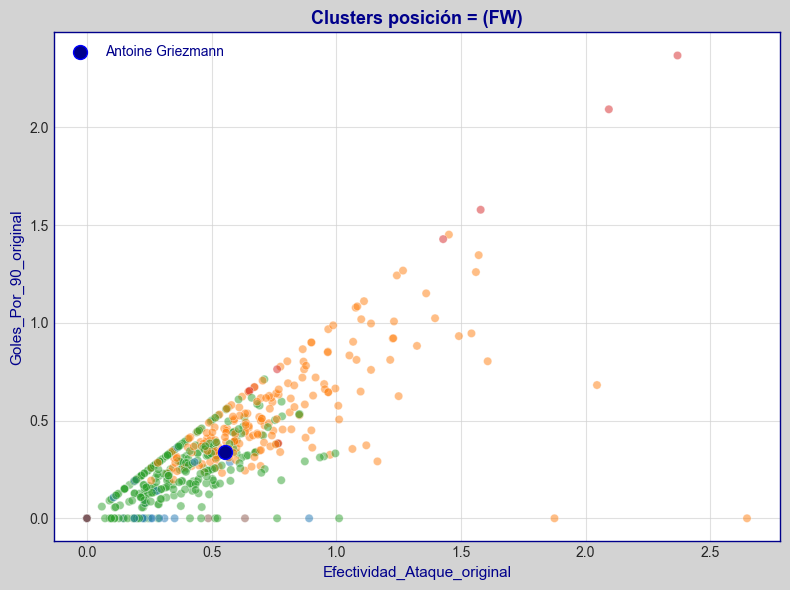

,Nombre,Equipo,Edad,distancia,Posicion,Efectividad_Ataque_original,Goles_Por_90_original,pca_x,pca_y
1483,Ludovic Ajorque,Brest,31,1.055470,FW,0.512157,0.465598,1.852749,-0.529880
1675,Mattia Zaccagni,Lazio,29,1.221110,FW,0.586865,0.335352,1.679552,-0.612777
2430,Vincenzo Grifo,Friburgo,31,1.570397,FW,0.756700,0.378350,2.051980,-1.333621
2263,Son Heung-min,Tottenham,32,1.616211,FW,0.775027,0.339074,1.667149,-0.996355
541,Danny Welbeck,Brighton,34,1.663105,FW,0.665770,0.423672,1.290466,-0.896546
949,Iago Aspas,Celta Vigo,37,1.742849,FW,0.701133,0.509915,1.847962,-1.467036
208,Ante Budimir,Osasuna,33,1.767627,FW,0.697039,0.615034,2.221859,-0.163563
1029,Jacob Murphy,Newcastle,30,1.787392,FW,0.696429,0.267857,1.309069,-0.131633
433,Che Adams,Torino,28,1.841286,FW,0.495495,0.360360,1.672991,0.363316
1485,Luis Diaz,Liverpool,28,1.846219,FW,0.632432,0.437838,1.729403,-0.323617


In [12]:
entrenar_modelo("Antoine Griezmann", resultado_clusters, df_atletico)

### <u>Conclusiones entrenamiento 1er modelo</u>

1. Agrupamos los jugadores por posición (ya normalizados en 3.2).

2. Aplicamos KMeans para segmentar en clusters por tipo de jugador (preparar_datos_modelado en 3.3).

3. Creo una función llamada entrenar_modelo() que:
- Recibe el nombre de un jugador del Atleti;
- Lo localiza, detecta su posición y su cluster;
- Calcula distancia euclidiana entre él y el resto del cluster;
- Muestra los 10 jugadores más similares;
- Representa gráficamente su cluster con PCA.

4. Ejemplo: buscando a Koke (Jorge Resurrección):
- Se detecta como MF;
- Se identifica su cluster con jugadores similares como:

1.Jordan Ferri (Montpellier)

2. Pathe Ciss (Rayo)

3. Danilo Cataldi (Fiorentina)

4. Ilkay Gundogan (City)

- Todos ordenados por cercanía (distancia mínima primero).


De este modo no permite comparar perfiles reales en competiciones similares. Aísla características similares funcionalmente, sin confundir posiciones distintas. Base perfecta para aplicar KNN en la siguiente fase (4.2) sobre un conjunto reducido pero relevante.

## 4.2 Segundo Modelo (Knn para similitud de jugadores tras cluster relevante)

In [13]:
def entrenar_modelo_knn(jugador_atleti, resultado_clusters, df_atletico, df_general, df_porteros, df_mercado=None, df_equipos=None, top_n=10, graficar=True, metricas_extra=None):
    """
    Función completa para:
      1. Localizar el jugador en resultado_clusters (KMeans).
      2. Fusionar datos avanzados de df_general, df_porteros, df_mercado y df_equipos.
      3. Aplicar KNN sobre las variables numéricas.
      4. Mostrar una tabla y scatter plot con las métricas seleccionadas.
    
    Parámetros:
      - jugador_atleti: nombre del jugador (se aplican alias).
      - resultado_clusters: diccionario con clusters por posición.
      - df_atletico, df_general, df_porteros, df_mercado, df_equipos: DataFrames limpios.
      - top_n: número de jugadores similares a devolver.
      - graficar: si se desea mostrar el scatter.
      - metricas_extra: lista opcional de columnas adicionales a mostrar.
    """
    # Función para normalizar texto (quita acentos, espacios y pasa a minúsculas)
    def normalizar_texto(texto):
        if isinstance(texto, str):
            texto = texto.strip().lower()
            texto = unicodedata.normalize('NFKD', texto)
            return ''.join(c for c in texto if not unicodedata.combining(c))
        return texto

    # Alias de nombres
    alias_mapping = {
        "Musso": "Juan Musso", "Gimenez": "Jose Maria Gimenez", "Azpilicueta": "Cesar Azpilicueta",
        "Koke": "Jorge Resurreccion", "Gallagher": "Conor Gallagher", "De Paul": "Rodrigo De Paul",
        "Griezmann": "Antoine Griezmann", "Barrios": "Pablo Barrios", "Sorloth": "Alexander Sorloth",
        "Aleksander Sorloth": "Alexander Sorloth", "Sorloth": "Alexander Sørloth", "Alexander Sorloth": "Alexander Sørloth",
        "Correa": "Angel Correa", "Lemar": "Thomas Lemar", "Samu Lino": "Samuel Lino", "Lino": "Samu Lino",
        "Oblak": "Jan Oblak", "Llorente": "Marcos Llorente", "Lenglet": "Clement Lenglet",
        "Molina": "Nahuel Molina", "Riquelme": "Rodrigo Riquelme", "J. Alvarez": "Julian Alvarez", "Julian": "Julian Alvarez",
        "Witsel": "Axel Witsel", "J. Galan": "Javi Galan", "Galan": "Javi Galan", "Giuliano": "Giuliano Simeone",
        "Reinildo": "Reinildo Mandava", "Le Normand": "Robin Le Normand",
    }
    
    def aplicar_alias(x):
        return alias_mapping.get(x, x)
    
    # Aplicar alias en df_atletico, df_general y df_porteros
    df_atletico['Nombre'] = df_atletico['Nombre'].apply(aplicar_alias)
    df_general['Nombre'] = df_general['Nombre'].apply(aplicar_alias)
    df_porteros['Nombre'] = df_porteros['Nombre'].apply(aplicar_alias)

    # Verificar que el jugador esté en la plantilla
    jugador_real = alias_mapping.get(jugador_atleti, jugador_atleti)
    if jugador_real not in df_atletico['Nombre'].values:
        print(f"El jugador '{jugador_atleti}' no está en la plantilla del Atlético.")
        return

    # Obtener la posición (se asume que ya está limpia: GK, DF, MF o FW)
    posicion = df_atletico.loc[df_atletico['Nombre'] == jugador_real, 'Posicion'].values[0]
    if posicion not in ['GK', 'DF', 'MF', 'FW']:
        print(f"Posición '{posicion}' no es válida (esperado: GK, DF, MF o FW).")
        return
    posicion_basica = posicion

    # Seleccionar métricas específicas según la posición
    metricas_por_posicion = {
        'GK': ['Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original', 
            'Rendimiento_vs_Esperado_original', 'Actividad_Fuera_Area_original'],
        'DF': ['Contribucion_Defensiva_original', 'Eficiencia_Pases_original', 
            'Eficiencia_Duelos_Aereos_original', 'Eficiencia_Entradas_original', 
            'Acciones_Defensivas_90_original'],
        'MF': ['Creacion_Juego_90_original', 'Eficiencia_Pases_original', 
            'Creacion_Ocasiones_original', 'Eficiencia_Regates_original', 
            'Indice_Progresion_original', 'Contribucion_Defensiva_original'],
        'FW': ['Efectividad_Ataque_original', 'Goles_Por_90_original', 
            'Precision_Disparo_original', 'Goles_Sobre_xG_original', 
            'Disparos_Por_90_original', 'Eficiencia_Regates_original']
    }

    # Métricas comunes para todas las posiciones
    metricas_comunes = ['Altura', 'Pie', 'Media_edad', 'Posesion']

    # Combinar métricas específicas por posición con las comunes
    metricas_seleccionadas = metricas_por_posicion.get(posicion_basica, []) + metricas_comunes

    # Si se proporcionaron métricas extra, añadirlas
    if metricas_extra is not None:
        metricas_seleccionadas.extend(metricas_extra)

    # Eliminar duplicados preservando el orden
    metricas_seleccionadas = list(dict.fromkeys(metricas_seleccionadas))

    # Obtener el DataFrame de la posición desde resultado_clusters
    df_pos = resultado_clusters.get(posicion_basica, pd.DataFrame()).copy()
    if df_pos.empty:
        print(f"No hay datos para la posición '{posicion_basica}'.")
        return
    df_pos['Nombre'] = df_pos['Nombre'].apply(aplicar_alias)
    if jugador_real not in df_pos['Nombre'].values:
        print(f"El jugador '{jugador_real}' no está en los datos de la posición '{posicion_basica}'.")
        return

    # Seleccionar el cluster del jugador
    cluster_id = df_pos.loc[df_pos['Nombre'] == jugador_real, 'cluster'].values[0]
    df_cluster = df_pos[df_pos['cluster'] == cluster_id].copy()

    # 1. Fusionar Edad desde df_general (se extrae de df_general, que es la fuente principal de stats de campo)
    if 'Edad' in df_general.columns:
        df_cluster = df_cluster.merge(df_general[['Nombre', 'Edad', 'Nacimiento', 'Partidos', 'Posicion_2' ]].drop_duplicates(), on='Nombre', how='left')
   
    # 2. Fusionar datos de mercado (Valor, Contrato, Altura, Pie)
    if df_mercado is not None:
        df_mercado_temp = df_mercado[['Nombre', 'Valor', 'Contrato', 'Altura', 'Pie']].copy()
        df_mercado_temp['Nombre'] = df_mercado_temp['Nombre'].apply(lambda x: x.strip().lower())
        df_cluster['Nombre'] = df_cluster['Nombre'].apply(lambda x: x.strip().lower())
        df_cluster = df_cluster.merge(df_mercado_temp, on='Nombre', how='left')
    
    # 3. Fusionar datos de equipos (Media_edad, Posesion)
    if df_equipos is not None and 'Equipo' in df_cluster.columns:
        df_equipos_temp = df_equipos[['Equipo', 'Media_edad', 'Posesion']].copy()
        df_equipos_temp['Equipo'] = df_equipos_temp['Equipo'].apply(lambda x: x.strip().lower())
        df_cluster['Equipo'] = df_cluster['Equipo'].apply(lambda x: x.strip().lower())
        df_cluster = df_cluster.merge(df_equipos_temp, on='Equipo', how='left')
    
    # Rellenar valores numéricos con la mediana
    for col in df_cluster.select_dtypes(include=['float64', 'int64']).columns:
        df_cluster[col] = df_cluster[col].fillna(df_cluster[col].median())
    
    # Definir variables numéricas para KNN
    id_cols = ['Nombre', 'Equipo', 'Posicion', 'Nacionalidad', 'cluster', 'pca_x', 'pca_y']

    # Asegurar que tenemos suficientes características numéricas para KNN
    if posicion_basica == 'GK':
        # Para porteros, usar un enfoque simplificado
        # 1. Seleccionar solo columnas numéricas básicas que seguramente existen
        basic_cols = ['pca_x', 'pca_y']
        feature_cols = [col for col in basic_cols if col in df_cluster.columns]
        
        # 2. Añadir algunas columnas adicionales seguras (si existen)
        safe_cols = ['Edad', 'Minutos', 'Partidos', 'Nacimiento', 'cluster']
        for col in safe_cols:
            if col in df_cluster.columns and pd.api.types.is_numeric_dtype(df_cluster[col]):
                feature_cols.append(col)
        
        print(f"Usando columnas para portero: {feature_cols}")
    else:
        # Para jugadores de campo, usar el código original
        feature_cols = [col for col in df_cluster.columns 
                        if col not in id_cols 
                        and pd.api.types.is_numeric_dtype(df_cluster[col])]

    # Añadir métricas extra si se proporcionaron (para todas las posiciones)
    if metricas_extra is not None:
        for col in metricas_extra:
            if col in df_cluster.columns and col not in feature_cols:
                feature_cols.append(col)

    # Rellenar valores específicos
    if 'Partidos' in feature_cols:
        df_cluster['Partidos'] = df_cluster['Partidos'].fillna(0)  # Si no hay partidos, asumir 0

    if 'Nacimiento' in feature_cols:
        df_cluster['Nacimiento'] = df_cluster['Nacimiento'].fillna(2000)  # Valor por defecto

    # También puedes hacer esto de forma más general
    special_fills = {
        'Partidos': 0,
        'Nacimiento': 2000,
        # Añadir más columnas específicas si es necesario
    }

    for col, value in special_fills.items():
        if col in feature_cols:
            df_cluster[col] = df_cluster[col].fillna(value)

    # IMPORTANTE: Eliminar filas con NaN - una sola vez para todas las posiciones
    df_cluster = df_cluster.dropna(subset=feature_cols)
    if df_cluster.empty:
        print("No hay suficientes datos para ejecutar KNN.")
        return
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster[feature_cols])
    
    # Aplicar KNN
    knn = NearestNeighbors(n_neighbors=top_n + 1, metric='euclidean')
    knn.fit(X_scaled)
    
    # Normalizar el nombre del jugador para la búsqueda (los merges lo dejaron en minúsculas)
    jugador_real_norm = jugador_real.strip().lower()
    if jugador_real_norm not in df_cluster['Nombre'].values:
        print(f"El jugador '{jugador_real}' no se encontró tras los merges en df_cluster.")
        return
    
    idx_jugador = df_cluster[df_cluster['Nombre'] == jugador_real_norm].index[0]
    distancias, indices = knn.kneighbors([X_scaled[df_cluster.index.get_loc(idx_jugador)]])
    similares = df_cluster.iloc[indices[0]].copy()
    similares['distancia'] = distancias[0]
    similares = similares[similares['Nombre'] != jugador_real_norm].copy()
    
    # Columnas a mostrar (por defecto)
    columnas_resultado = ['Nombre', 'Equipo', 'Edad','Nacimiento', 'Valor', 'Contrato', 'Posicion_2', 'Pie', 'Altura','Partidos', 'Min_tot',  'distancia']
    if posicion_basica == 'GK':
        columnas_resultado += ['Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original']
        eje_x, eje_y = 'Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original'
    elif posicion_basica == 'DF':
        columnas_resultado += ['Contribucion_Defensiva_original', 'Eficiencia_Pases_original']
        eje_x, eje_y = 'Contribucion_Defensiva_original', 'Eficiencia_Pases_original'
    elif posicion_basica == 'MF':
        columnas_resultado += ['Creacion_Juego_90_original', 'Eficiencia_Pases_original']
        eje_x, eje_y = 'Creacion_Juego_90_original', 'Eficiencia_Pases_original'
    elif posicion_basica == 'FW':
        columnas_resultado += ['Efectividad_Ataque_original', 'Goles_Por_90_original']
        eje_x, eje_y = 'Efectividad_Ataque_original', 'Goles_Por_90_original'
        
    # Formateo final: asegurar que 'Contrato' sea enteros, y 'Valor' se muestre formateado
    
    if 'Contrato' in similares.columns:
        similares['Contrato'] = similares['Contrato'].astype(int)
    if 'Valor' in similares.columns:
        similares['Valor'] = similares['Valor'].apply(lambda x: f"{int(x):,} €")

    # Formatear nombres: primera letra en mayúscula
    for col in ['Nombre', 'Equipo']:
        if col in similares.columns:
            similares[col] = similares[col].str.title()
    
    if 'Edad_original' in similares.columns:
        similares = similares.rename(columns={'Edad_original': 'Edad'})
    
    if 'Minutos_original' in similares.columns:
        similares = similares.rename(columns={'Minutos_original': 'Min_tot'})

    # Mostrar tabla de resultados
    cols_final = [col for col in columnas_resultado if col in similares.columns]
    print(f"🔎 Jugadores similares a {jugador_real} según KNN ({posicion_basica})")
    display(similares[cols_final].style.format(precision=2).set_caption("Top jugadores similares (KNN)"))
    
    # Graficar scatter con las dos métricas clave y nombres de los jugadores
    if graficar and eje_x in similares.columns and eje_y in similares.columns:
        plt.figure(figsize=(8, 6), facecolor="lightgrey")
        sns.scatterplot(data=similares, x=eje_x, y=eje_y, color='grey', s=60, alpha=0.6)
        # Punto del jugador
        jugador_coords = df_cluster.loc[df_cluster['Nombre'] == jugador_real_norm, [eje_x, eje_y]].iloc[0]
        plt.scatter(jugador_coords[eje_x], jugador_coords[eje_y], color='darkblue', s=100, label=jugador_real, edgecolor='blue')
        # Mostrar nombres de cada jugador en el scatter
        for i, row in similares.iterrows():
            plt.text(row[eje_x], row[eje_y], row['Nombre'], fontsize=9, color='darkblue')
        ax = plt.gca()
        ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_color('darkblue')
            spine.set_linewidth(1)
        ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)
        plt.title(f'Jugadores similares vía KNN a {jugador_real}', color='darkblue', weight='bold')
        plt.xlabel(eje_x.replace('_original', '').replace('_', ' ').title(), color='darkblue')
        plt.ylabel(eje_y.replace('_original', '').replace('_', ' ').title(), color='darkblue')
        plt.legend()
        plt.show()
    
    return similares[cols_final]

🔎 Jugadores similares a Antoine Griezmann según KNN (FW)


,Nombre,Equipo,Edad,Nacimiento,Valor,Contrato,Posicion_2,Pie,Altura,Partidos,Min_tot,distancia,Efectividad_Ataque_original,Goles_Por_90_original
127,Ludovic Ajorque,Brest,31,1994,"4,000,000 €",2025,Centre-Forward,Izquierdo,1.96,24,1933,2.91,0.51,0.47
144,Mattia Zaccagni,Lazio,29,1995,"20,000,000 €",2029,Left Winger,Derecho,1.77,27,2147,3.42,0.59,0.34
85,Iago Aspas,Celta Vigo,37,1987,"2,500,000 €",2026,MF,Izquierdo,1.76,22,1412,3.51,0.70,0.51
190,Romelu Lukaku,Napoli,31,1993,"22,000,000 €",2027,Centre-Forward,Izquierdo,1.91,28,2179,3.54,0.78,0.45
208,Vincenzo Grifo,Friburgo,31,1993,"7,500,000 €",2025,MF,Derecho,1.80,27,1903,3.65,0.76,0.38
94,Jacob Murphy,Newcastle,30,1995,"16,000,000 €",2027,Right Winger,Derecho,1.79,25,1680,3.80,0.70,0.27
16,Ante Budimir,Osasuna,33,1991,"5,000,000 €",2027,Centre-Forward,Izquierdo,1.90,29,2195,3.99,0.70,0.62
118,Kike,Alaves,35,1989,"19,000,000 €",2027,FW,nan,1.82,27,1864,4.01,0.53,0.53
43,Che Adams,Torino,28,1996,"15,000,000 €",2027,Centre-Forward,Derecho,1.79,28,1998,4.14,0.50,0.36
182,Raul Jimenez,Fulham,33,1991,"5,000,000 €",2025,Centre-Forward,Derecho,1.87,29,1836,4.29,0.64,0.49


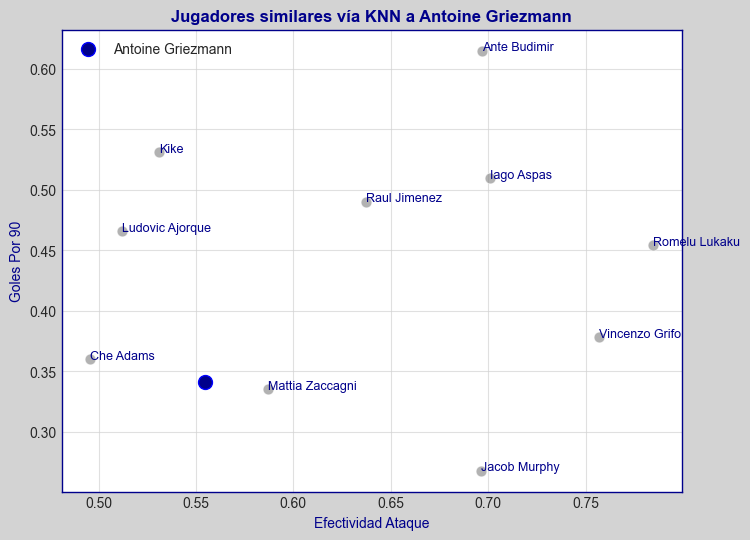

In [14]:
resultados_knn = entrenar_modelo_knn("Griezmann", resultado_clusters, df_atletico, df_general, df_porteros, df_mercado, df_equipos)

### <u>Muestra de Modelo2, KNN</u>

1. La función entrenar_modelo_knn realiza lo siguiente:
- Localiza al jugador (aplicando alias para corregir nombres) en la plantilla del Atlético (df_atletico) y extrae su posición;
- Selecciona el cluster relevante (obtenido previamente mediante KMeans) para esa posición;
- Fusiona datos adicionales:

La edad y otras métricas desde df_general (o df_porteros para GK).

Datos de mercado (Valor, Contrato, Altura, Pie) desde df_mercado.

Estadísticas de equipo (Media_edad, Posesion) desde df_equipos.

- Prepara y estandariza las variables numéricas que se usan para calcular similitudes;
- Aplica KNN para encontrar los jugadores más cercanos en el espacio de características;
- Muestra una tabla final con las columnas clave (por ejemplo, Nombre, Equipo, Edad, Valor, Contrato y las métricas específicas por posición);
- Genera un scatter plot que compara dos métricas clave (definidas según la posición) y sobre el gráfico se muestran los nombres de los jugadores.

Esta función ofrece una vista detallada de los jugadores más similares al jugador elegido, utilizando tanto datos estadísticos como de mercado y equipo, lo que facilita la comparación para posteriores evaluaciones.

# 5. Evaluación



### <u>Intención Evaluación de Modelos</u>

1. Evaluación de K-Means:
- Medir la calidad de los clusters;
- Analizar la distribución de los clusters;
- Calcular el Silhouette Score (cohesión interna);
- Examinar la homogeneidad dentro de cada cluster;
- Visualizar los centros de los clusters.

2. Evaluación de KNN:
- Analizar la distribución de clusters de jugadores similares;
- Calcular distancias medias entre jugadores;
- Examinar variaciones en características clave;
- Proporcionar un resumen por posición.

### Estas funciones de evaluación mejoradas ofrecen:

- Análisis cuantitativo con métricas estándar como Silhouette Score y Calinski-Harabasz;
- Análisis cualitativo con visualizaciones y tablas;
- Solución al problema de nombres usando normalización y alias;
- Compatibilidad total con las funciones anteriores;
- Formato coherente con el estilo que ya se está utilizando.

## 5.1 Evaluación de los resultados del Clustering

In [15]:
# Alias de nombres para normalizar inconsistencias
alias_mapping = {
    "Musso": "Juan Musso", "Gimenez": "Jose Maria Gimenez", "Azpilicueta": "Cesar Azpilicueta",
    "Koke": "Jorge Resurreccion", "Gallagher": "Conor Gallagher", "De Paul": "Rodrigo De Paul",
    "Griezmann": "Antoine Griezmann", "Barrios": "Pablo Barrios", "Sorloth": "Alexander Sorloth",
    "Aleksander Sorloth": "Alexander Sorloth", "Sorloth": "Alexander Sørloth", "Alexander Sorloth": "Alexander Sørloth",
    "Correa": "Angel Correa", "Lemar": "Thomas Lemar", "Samu Lino": "Samuel Lino", "Lino": "Samu Lino",
    "Oblak": "Jan Oblak", "Llorente": "Marcos Llorente", "Lenglet": "Clement Lenglet",
    "Molina": "Nahuel Molina", "Riquelme": "Rodrigo Riquelme", "J. Alvarez": "Julian Alvarez", "Julian": "Julian Alvarez",
    "Witsel": "Axel Witsel", "J. Galan": "Javi Galan", "Galan": "Javi Galan", "Giuliano": "Giuliano Simeone",
    "Reinildo": "Reinildo Mandava", "Le Normand": "Robin Le Normand",
}

# Función Cluster K-Means
def evaluar_clustering(resultado_clusters, df_por_posicion, graficar=True):
    """
    Evalúa la calidad de los clusters generados para cada posición
    
    Args:
        resultado_clusters: Diccionario con DataFrames que incluyen etiquetas de cluster
        df_por_posicion: Diccionario con DataFrames originales por posición
        graficar: Booleano para indicar si se deben mostrar gráficos
        
    Returns:
        dict: Diccionario con métricas de evaluación por posición
    """ 
    evaluation_results = {}
    
    print("📊 Evaluación de Clustering (K-Means)")
    print("="*70)
    
    for pos, df in resultado_clusters.items():
        if df.empty or 'cluster' not in df.columns:
            print(f"No hay suficientes datos para evaluar clustering en posición {pos}")
            continue
            
        # Identificar columnas para evaluación (las mismas usadas para clustering)
        non_numeric_cols = ['Nombre', 'Equipo', 'Posicion', 'Posicion_2', 'Nacionalidad', 
                           'cluster', 'pca_x', 'pca_y']
        id_cols = [col for col in non_numeric_cols if col in df.columns]
        
        feature_cols = [col for col in df.columns 
                       if col not in id_cols 
                       and not col.endswith('_original')
                       and pd.api.types.is_numeric_dtype(df[col])]
        
        # Verificar que haya suficientes características
        if len(feature_cols) < 2:
            print(f"Insuficientes características numéricas para {pos}")
            continue
        
        X = df[feature_cols].values
        labels = df['cluster'].values
        
        print(f"\n🔹 Posición: {pos} - {len(df)} jugadores en {len(np.unique(labels))} clusters")
        
        # Métricas de evaluación
        metrics = {}
        
        # 1. Silhouette Score (mide la similitud de un objeto a su propio cluster vs. otros clusters)
        try:
            silhouette_avg = silhouette_score(X, labels)
            print(f"  • Silhouette Score: {silhouette_avg:.4f} [-1 a 1, mayor es mejor]")
            metrics['silhouette_score'] = silhouette_avg
        except Exception as e:
            print(f"  • Error calculando Silhouette Score: {e}")
            metrics['silhouette_score'] = None
        
        # 2. Calinski-Harabasz Index (ratio varianza entre clusters / varianza dentro de clusters)
        try:
            ch_score = calinski_harabasz_score(X, labels)
            print(f"  • Calinski-Harabasz Score: {ch_score:.2f} [mayor es mejor]")
            metrics['calinski_harabasz_score'] = ch_score
        except Exception as e:
            print(f"  • Error calculando Calinski-Harabasz Score: {e}")
            metrics['calinski_harabasz_score'] = None
        
        # 3. Distribución de clusters
        cluster_sizes = df['cluster'].value_counts().sort_index()
        cluster_distribution = {f"Cluster {i}": count for i, count in enumerate(cluster_sizes)}
        
        print("\n  • Distribución de jugadores por cluster:")
        for cluster, count in cluster_distribution.items():
            print(f"    - {cluster}: {count} jugadores ({count/len(df)*100:.1f}%)")
        
        # 4. Homogeneidad por cluster (desviación estándar media de características)
        homogeneity = {}
        for cluster_id in df['cluster'].unique():
            cluster_data = df[df['cluster'] == cluster_id][feature_cols]
            std_mean = cluster_data.std().mean()
            homogeneity[f"Cluster {cluster_id}"] = std_mean
        
        print("\n  • Homogeneidad por cluster (desviación estándar media, menor es mejor):")
        for cluster, std in homogeneity.items():
            print(f"    - {cluster}: {std:.4f}")
        
        # Visualización
        if graficar:
            # Definir métricas para visualización según posición
            if pos == 'GK':
                eje_x, eje_y = 'Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original'
            elif pos == 'DF':
                eje_x, eje_y = 'Contribucion_Defensiva_original', 'Eficiencia_Pases_original'
            elif pos == 'MF':
                eje_x, eje_y = 'Creacion_Juego_90_original', 'Eficiencia_Pases_original'
            elif pos == 'FW':
                eje_x, eje_y = 'Efectividad_Ataque_original', 'Goles_Por_90_original'
            else:
                print(f"  • No hay métricas específicas para visualización de {pos}")
                continue
            
            # Verificar que existan las columnas necesarias
            if eje_x not in df.columns or eje_y not in df.columns:
                print(f"  • No se pueden graficar {eje_x} o {eje_y}")
                
                # Intentar usar PCA como alternativa
                if 'pca_x' in df.columns and 'pca_y' in df.columns:
                    print("  • Usando proyección PCA para visualización")
                    eje_x, eje_y = 'pca_x', 'pca_y'
                else:
                    continue
            
            # Gráfico de dispersión con clusters
            plt.figure(figsize=(10, 7), facecolor="lightgrey")
            scatter = sns.scatterplot(
                data=df, 
                x=eje_x, 
                y=eje_y, 
                hue='cluster', 
                palette='viridis', 
                alpha=0.7,
                s=80
            )
            
            # Estilo del gráfico
            plt.title(f'Evaluación de Clusters - Posición {pos}', fontsize=15, color='darkblue', weight='bold')
            plt.xlabel(eje_x.replace('_original', '').replace('_', ' ').title(), color='darkblue')
            plt.ylabel(eje_y.replace('_original', '').replace('_', ' ').title(), color='darkblue')
            
            # Personalización del fondo y ejes
            ax = plt.gca()
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('darkblue')
                spine.set_linewidth(1)
            ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)
            
            # Cambiar etiquetas de leyenda a "Cluster N"
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, [f"Cluster {l}" for l in labels], title="Grupos")
            
            plt.tight_layout()
            plt.show()
            
            # Mostrar tabla resumen de clusters
            print("\n  • Características de los clusters:")
            cluster_summary = df.groupby('cluster')[feature_cols].mean().reset_index()
            # Convertir a formato legible (4 decimales máximo)
            for col in feature_cols:
                cluster_summary[col] = cluster_summary[col].round(4)
            cluster_summary['Tamaño'] = df['cluster'].value_counts().sort_index().values
            
            display(cluster_summary.style
                   .set_caption(f"Resumen de clusters para posición {pos}")
                   .background_gradient(subset=feature_cols, cmap='Blues'))
        
        # Guardar resultados
        evaluation_results[pos] = {
            'metrics': metrics,
            'distribution': cluster_distribution,
            'homogeneity': homogeneity,
            'features_used': feature_cols
        }
    
    return evaluation_results

## 5.2 Evaluación de los resultados de KNN

In [16]:
# Alias de nombres para normalizar inconsistencias
alias_mapping = {
    "Musso": "Juan Musso", "Gimenez": "Jose Maria Gimenez", "Azpilicueta": "Cesar Azpilicueta",
    "Koke": "Jorge Resurreccion", "Gallagher": "Conor Gallagher", "De Paul": "Rodrigo De Paul",
    "Griezmann": "Antoine Griezmann", "Barrios": "Pablo Barrios", "Sorloth": "Alexander Sorloth",
    "Aleksander Sorloth": "Alexander Sorloth", "Sorloth": "Alexander Sørloth", "Alexander Sorloth": "Alexander Sørloth",
    "Correa": "Angel Correa", "Lemar": "Thomas Lemar", "Samu Lino": "Samuel Lino", "Lino": "Samu Lino",
    "Oblak": "Jan Oblak", "Llorente": "Marcos Llorente", "Lenglet": "Clement Lenglet",
    "Molina": "Nahuel Molina", "Riquelme": "Rodrigo Riquelme", "J. Alvarez": "Julian Alvarez", "Julian": "Julian Alvarez",
    "Witsel": "Axel Witsel", "J. Galan": "Javi Galan", "Galan": "Javi Galan", "Giuliano": "Giuliano Simeone",
    "Reinildo": "Reinildo Mandava", "Le Normand": "Robin Le Normand",
}

def evaluar_knn(jugadores_atleti, resultado_clusters, df_atletico, df_general, df_porteros, 
                df_mercado, df_equipos, graficar=True):
    """
    Evalúa la calidad de las recomendaciones KNN para jugadores del Atlético.
    
    Args:
        jugadores_atleti: Lista de nombres de jugadores a evaluar
        resultado_clusters: Resultado del clustering K-Means
        df_atletico, df_general, df_porteros, df_mercado, df_equipos: DataFrames
        graficar: Booleano para indicar si se deben mostrar gráficos
        
    Returns:
        dict: Diccionario con resultados de la evaluación
    """   
    
    # Si se pasa un solo jugador, convertir a lista
    if isinstance(jugadores_atleti, str):
        jugadores_atleti = [jugadores_atleti]
    
    resultados_evaluacion = {}
    
    print("🔎 Evaluación de Recomendaciones KNN")
    print("="*70)
    
    for jugador in jugadores_atleti:
        jugador_real = alias_mapping.get(jugador, jugador)
        
        # Verificar que el jugador exista en la plantilla
        if jugador_real not in df_atletico['Nombre'].values:
            print(f"El jugador '{jugador}' no está en la plantilla del Atlético.")
            continue
        
        print(f"\n Evaluando similitud para: {jugador_real}")
        
        # Obtener posición del jugador
        posicion = df_atletico[df_atletico['Nombre'] == jugador_real]['Posicion'].values[0]
        
        # Verificar validez de la posición
        if posicion not in ['GK', 'DF', 'MF', 'FW']:
            print(f"Posición '{posicion}' no reconocida (debe ser GK, DF, MF o FW).")
            continue
        
        # Obtener resultados KNN
        similares = entrenar_modelo_knn(
            jugador, 
            resultado_clusters, 
            df_atletico, 
            df_general, 
            df_porteros, 
            df_mercado, 
            df_equipos,
            graficar=False  # Se desactiva el gráfico original
        )
        
        if similares is None or similares.empty:
            print(f"No se encontraron jugadores similares para {jugador_real}.")
            continue
        
        # Análisis de resultados
        print(f"\n  • Se encontraron {len(similares)} jugadores similares:")
        
        # 1. Análisis de distancias
        distancia_media = similares['distancia'].mean()
        distancia_min = similares['distancia'].min()
        distancia_max = similares['distancia'].max()
        
        print(f"  • Distancia media: {distancia_media:.4f}")
        print(f"  • Rango de distancias: {distancia_min:.4f} - {distancia_max:.4f}")
        
        # 2. Análisis de distribución por equipos
        if 'Equipo' in similares.columns:
            equipos = similares['Equipo'].value_counts()
            print("\n  • Distribución por equipos:")
            for equipo, count in equipos.items():
                if count > 1:  # Solo mostrar equipos con más de 1 jugador
                    print(f"    - {equipo}: {count} jugadores")
        
        # 3. Análisis de características clave según posición
        if posicion == 'GK':
            cols_analisis = ['Eficiencia_Paradas_original', 'Porcentaje_Porterias_Cero_original']
            eje_x, eje_y = cols_analisis
        elif posicion == 'DF':
            cols_analisis = ['Contribucion_Defensiva_original', 'Eficiencia_Pases_original']
            eje_x, eje_y = cols_analisis
        elif posicion == 'MF':
            cols_analisis = ['Creacion_Juego_90_original', 'Eficiencia_Pases_original']
            eje_x, eje_y = cols_analisis
        elif posicion == 'FW':
            cols_analisis = ['Efectividad_Ataque_original', 'Goles_Por_90_original']
            eje_x, eje_y = cols_analisis
        
        # Verificar que las columnas existan
        cols_disponibles = [col for col in cols_analisis if col in similares.columns]
        
        if cols_disponibles:
            print("\n  • Estadísticas de características clave:")
            for col in cols_disponibles:
                media = similares[col].mean()
                min_val = similares[col].min()
                max_val = similares[col].max()
                print(f"    - {col.replace('_original', '').replace('_', ' ').title()}: ")
                print(f"      Media: {media:.4f}, Rango: {min_val:.4f} - {max_val:.4f}")
        
        # Visualización
        if graficar and eje_x in similares.columns and eje_y in similares.columns:
            # Obtener datos del cluster donde está el jugador
            df_pos = resultado_clusters[posicion].copy()
            
            # Localizar el cluster del jugador
            jugador_norm = jugador_real.strip().lower()
            df_pos['Nombre'] = df_pos['Nombre'].apply(lambda x: x.strip().lower())
            cluster_id = df_pos[df_pos['Nombre'] == jugador_norm]['cluster'].values[0] if jugador_norm in df_pos['Nombre'].values else None
            
            if cluster_id is not None:
                # Gráfico de dispersión
                plt.figure(figsize=(10, 7), facecolor="lightgrey")
                
                # Todos los jugadores del mismo cluster
                cluster_df = df_pos[df_pos['cluster'] == cluster_id]
                sns.scatterplot(
                    data=cluster_df, 
                    x=eje_x, 
                    y=eje_y, 
                    color='lightgrey',
                    alpha=0.5,
                    s=50,
                    label=f'Cluster {cluster_id}'
                )
                
                # Jugadores similares recomendados
                similares['Nombre'] = similares['Nombre'].apply(lambda x: x.strip().lower())
                sns.scatterplot(
                    data=similares, 
                    x=eje_x, 
                    y=eje_y, 
                    color='green',
                    s=100,
                    label='Recomendados'
                )
                
                # Jugador evaluado
                jugador_data = df_pos[df_pos['Nombre'] == jugador_norm]
                plt.scatter(
                    jugador_data[eje_x], 
                    jugador_data[eje_y],
                    color='darkblue', 
                    s=200, 
                    edgecolor='white',
                    linewidth=2,
                    label=jugador_real
                )
                
                # Añadir etiquetas a los similares
                for i, row in similares.iterrows():
                    plt.text(
                        row[eje_x], 
                        row[eje_y], 
                        row['Nombre'].title(),
                        fontsize=8, 
                        color='darkgreen',
                        ha='center',
                        va='bottom'
                    )
                
                # Estilo del gráfico
                plt.title(f'Evaluación de similitud para {jugador_real} ({posicion})', 
                          fontsize=15, color='darkblue', weight='bold')
                plt.xlabel(eje_x.replace('_original', '').replace('_', ' ').title(), color='darkblue')
                plt.ylabel(eje_y.replace('_original', '').replace('_', ' ').title(), color='darkblue')
                
                # Personalización
                ax = plt.gca()
                ax.set_facecolor('white')
                for spine in ax.spines.values():
                    spine.set_color('darkblue')
                    spine.set_linewidth(1)
                ax.grid(True, color='lightgray', linestyle='-', alpha=0.7)
                
                plt.legend(loc='best')
                plt.tight_layout()
                plt.show()
            
            # Tabla resumen de recomendaciones
            print("\n  • Tabla de jugadores recomendados:")
            
            # Preparar tabla para mostrar
            tabla_display = similares.copy()
            if 'Nombre' in tabla_display.columns:
                tabla_display['Nombre'] = tabla_display['Nombre'].str.title()
            if 'Equipo' in tabla_display.columns:
                tabla_display['Equipo'] = tabla_display['Equipo'].str.title()
            
            display(tabla_display.style
                  .background_gradient(subset=['distancia'], cmap='Greens_r')
                  .format(precision=2)
                  .set_caption(f"Jugadores similares a {jugador_real} ({posicion})"))
        
        # Guardar resultados
        resultados_evaluacion[jugador_real] = {
            'posicion': posicion,
            'num_similares': len(similares),
            'distancia_media': distancia_media,
            'rango_distancias': (distancia_min, distancia_max),
            'similares': similares
        }
    
    # Mostrar resumen general
    if resultados_evaluacion:
        print("\nResumen general de la evaluación:")
        tabla_resumen = []
        
        for jugador, datos in resultados_evaluacion.items():
            tabla_resumen.append({
                'Jugador': jugador,
                'Posición': datos['posicion'],
                'Recomendaciones': datos['num_similares'],
                'Distancia Media': round(datos['distancia_media'], 4)
            })
        
        df_resumen = pd.DataFrame(tabla_resumen)
        display(df_resumen.style
              .background_gradient(subset=['Distancia Media'], cmap='Blues_r')
              .set_caption("Resumen de evaluación KNN"))
    
    return resultados_evaluacion


========================🔍 EVALUACIÓN COMPLETA DE MODELOS========================

Análisis para: Antoine Griezmann (Posición: FW)

ANÁLISIS DE CLUSTER
📊 Evaluación de Clustering (K-Means)

🔹 Posición: FW - 689 jugadores en 6 clusters
  • Silhouette Score: 0.1672 [-1 a 1, mayor es mejor]
  • Calinski-Harabasz Score: 96.00 [mayor es mejor]

  • Distribución de jugadores por cluster:
    - Cluster 0: 98 jugadores (14.2%)
    - Cluster 1: 196 jugadores (28.4%)
    - Cluster 2: 301 jugadores (43.7%)
    - Cluster 3: 9 jugadores (1.3%)
    - Cluster 4: 6 jugadores (0.9%)
    - Cluster 5: 79 jugadores (11.5%)

  • Homogeneidad por cluster (desviación estándar media, menor es mejor):
    - Cluster 5: 0.5804
    - Cluster 2: 0.6457
    - Cluster 0: 0.7252
    - Cluster 1: 0.7811
    - Cluster 4: 1.3751
    - Cluster 3: 1.1303


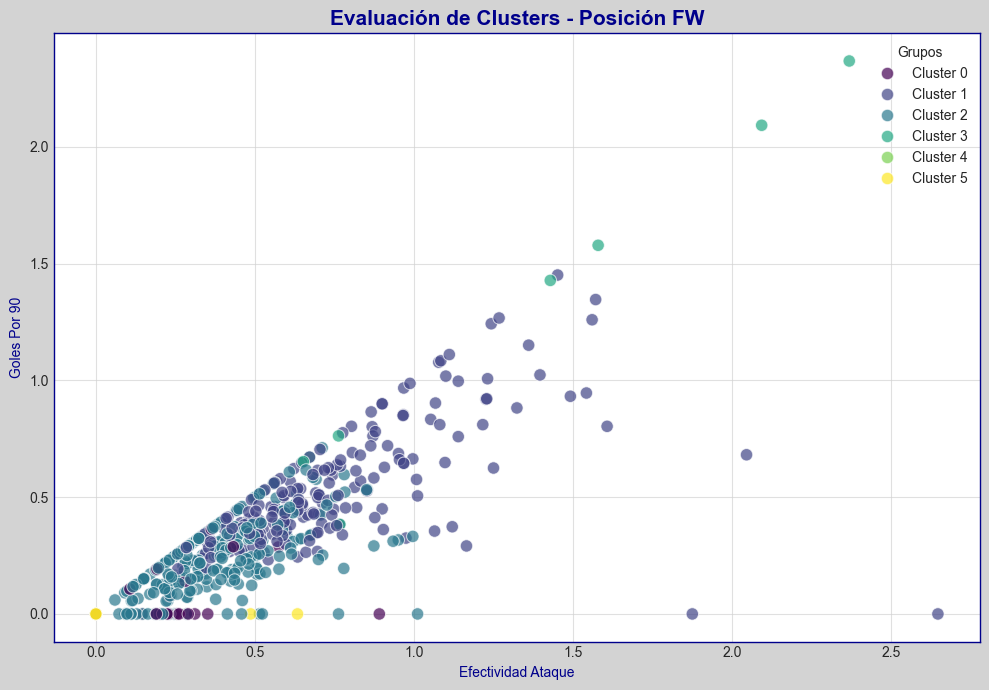


  • Características de los clusters:


,cluster,Edad,Minutos,Efectividad_Ataque,Precision_Disparo,Eficiencia_Ofensiva,Goles_Sobre_xG,Goles_Por_90,Disparos_Por_90,Eficiencia_Regates,Creacion_Ocasiones,Eficiencia_Duelos_Aereos,Tamaño
0,0,-0.049700,-0.835700,-0.905300,-0.983600,-0.629900,-0.279500,-0.866500,-0.171000,0.186800,-0.170700,0.967300,98
1,1,0.048900,0.602300,0.954100,0.482500,0.484400,0.984700,0.918100,0.140800,0.247500,0.126700,0.179900,196
2,2,0.225000,0.215600,-0.106100,0.310300,-0.220100,-0.556800,-0.152800,-0.024700,0.151800,0.032100,-0.064100,301
3,3,-0.727800,-0.872700,2.215500,1.235800,6.546500,0.963700,3.144900,-0.057400,-0.186500,-0.101300,-0.545000,9
4,4,-1.098200,-1.175500,-1.056800,1.258300,-0.754500,-0.075400,-0.917700,7.843400,-0.105700,1.643900,-0.504700,6
5,5,-0.750500,-1.090600,-1.012100,-1.395500,-0.270200,-0.078900,-0.909200,-0.632100,-1.394700,-0.338200,-1.301700,79



🔎 ANÁLISIS DE SIMILITUD
🔎 Evaluación de Recomendaciones KNN

 Evaluando similitud para: Antoine Griezmann
🔎 Jugadores similares a Antoine Griezmann según KNN (FW)


,Nombre,Equipo,Edad,Nacimiento,Valor,Contrato,Posicion_2,Pie,Altura,Partidos,Min_tot,distancia,Efectividad_Ataque_original,Goles_Por_90_original
127,Ludovic Ajorque,Brest,31,1994,"4,000,000 €",2025,Centre-Forward,Izquierdo,1.96,24,1933,2.91,0.51,0.47
144,Mattia Zaccagni,Lazio,29,1995,"20,000,000 €",2029,Left Winger,Derecho,1.77,27,2147,3.42,0.59,0.34
85,Iago Aspas,Celta Vigo,37,1987,"2,500,000 €",2026,MF,Izquierdo,1.76,22,1412,3.51,0.70,0.51
190,Romelu Lukaku,Napoli,31,1993,"22,000,000 €",2027,Centre-Forward,Izquierdo,1.91,28,2179,3.54,0.78,0.45
208,Vincenzo Grifo,Friburgo,31,1993,"7,500,000 €",2025,MF,Derecho,1.80,27,1903,3.65,0.76,0.38
94,Jacob Murphy,Newcastle,30,1995,"16,000,000 €",2027,Right Winger,Derecho,1.79,25,1680,3.80,0.70,0.27
16,Ante Budimir,Osasuna,33,1991,"5,000,000 €",2027,Centre-Forward,Izquierdo,1.90,29,2195,3.99,0.70,0.62
118,Kike,Alaves,35,1989,"19,000,000 €",2027,FW,nan,1.82,27,1864,4.01,0.53,0.53
43,Che Adams,Torino,28,1996,"15,000,000 €",2027,Centre-Forward,Derecho,1.79,28,1998,4.14,0.50,0.36
182,Raul Jimenez,Fulham,33,1991,"5,000,000 €",2025,Centre-Forward,Derecho,1.87,29,1836,4.29,0.64,0.49



  • Se encontraron 10 jugadores similares:
  • Distancia media: 3.7263
  • Rango de distancias: 2.9057 - 4.2870

  • Distribución por equipos:

  • Estadísticas de características clave:
    - Efectividad Ataque: 
      Media: 0.6399, Rango: 0.4955 - 0.7848
    - Goles Por 90: 
      Media: 0.4408, Rango: 0.2679 - 0.6150


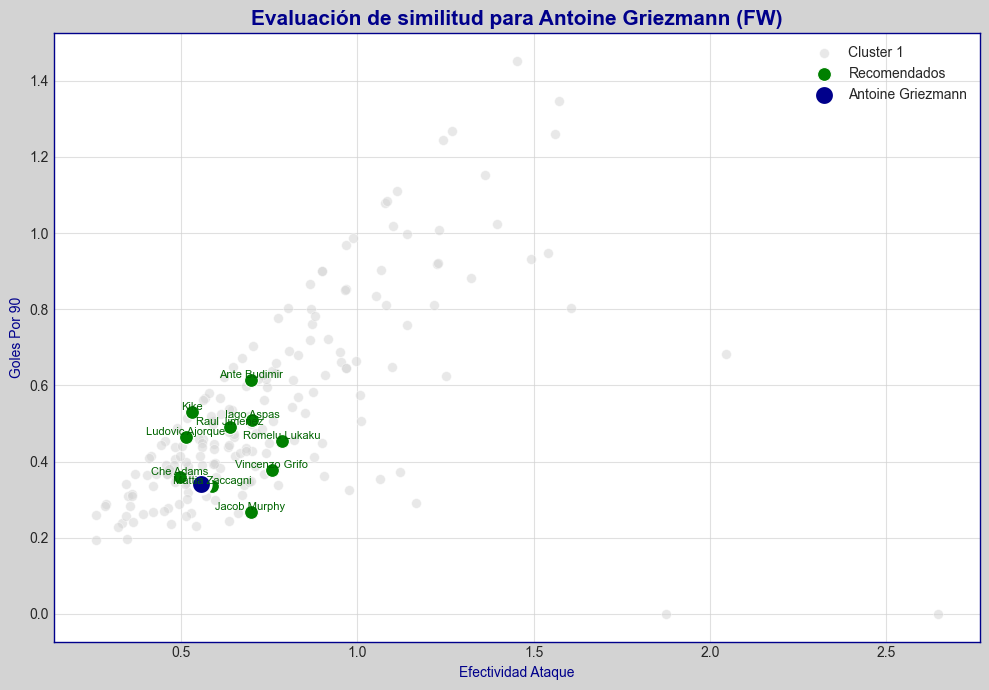


  • Tabla de jugadores recomendados:


,Nombre,Equipo,Edad,Nacimiento,Valor,Contrato,Posicion_2,Pie,Altura,Partidos,Min_tot,distancia,Efectividad_Ataque_original,Goles_Por_90_original
127,Ludovic Ajorque,Brest,31,1994,"4,000,000 €",2025,Centre-Forward,Izquierdo,1.96,24,1933,2.91,0.51,0.47
144,Mattia Zaccagni,Lazio,29,1995,"20,000,000 €",2029,Left Winger,Derecho,1.77,27,2147,3.42,0.59,0.34
85,Iago Aspas,Celta Vigo,37,1987,"2,500,000 €",2026,MF,Izquierdo,1.76,22,1412,3.51,0.70,0.51
190,Romelu Lukaku,Napoli,31,1993,"22,000,000 €",2027,Centre-Forward,Izquierdo,1.91,28,2179,3.54,0.78,0.45
208,Vincenzo Grifo,Friburgo,31,1993,"7,500,000 €",2025,MF,Derecho,1.80,27,1903,3.65,0.76,0.38
94,Jacob Murphy,Newcastle,30,1995,"16,000,000 €",2027,Right Winger,Derecho,1.79,25,1680,3.80,0.70,0.27
16,Ante Budimir,Osasuna,33,1991,"5,000,000 €",2027,Centre-Forward,Izquierdo,1.90,29,2195,3.99,0.70,0.62
118,Kike,Alaves,35,1989,"19,000,000 €",2027,FW,nan,1.82,27,1864,4.01,0.53,0.53
43,Che Adams,Torino,28,1996,"15,000,000 €",2027,Centre-Forward,Derecho,1.79,28,1998,4.14,0.50,0.36
182,Raul Jimenez,Fulham,33,1991,"5,000,000 €",2025,Centre-Forward,Derecho,1.87,29,1836,4.29,0.64,0.49



Resumen general de la evaluación:


,Jugador,Posición,Recomendaciones,Distancia Media
0,Antoine Griezmann,FW,10,3.726300



Evaluación completa para Antoine Griezmann finalizada


In [17]:
# 5. EVALUACIÓN DE MODELOS PARA UN JUGADOR ESPECÍFICO
print("\n" + "🔍 EVALUACIÓN COMPLETA DE MODELOS".center(80, "="))

# Selecciona el jugador a evaluar
jugador_a_evaluar = "Antoine Griezmann"  # Cambiar aquí para analizar otro jugador

jugador_real = alias_mapping.get(jugador_a_evaluar, jugador_a_evaluar)
if jugador_real in df_atletico['Nombre'].values:
    posicion = df_atletico[df_atletico['Nombre'] == jugador_real]['Posicion'].values[0]
    
    print(f"\nAnálisis para: {jugador_real} (Posición: {posicion})")
    
    # PARTE 1: Evaluación del cluster donde está el jugador
    print("\nANÁLISIS DE CLUSTER")
    resultado_filtrado = {posicion: resultado_clusters[posicion]}
    df_filtrado = {posicion: df_por_posicion[posicion]}
    evaluation_cluster = evaluar_clustering(resultado_filtrado, df_filtrado)
    
    # PARTE 2: Evaluación de jugadores similares con KNN
    print("\n🔎 ANÁLISIS DE SIMILITUD")
    knn_evaluation = evaluar_knn(jugador_a_evaluar, resultado_clusters, df_atletico, 
                               df_general, df_porteros, df_mercado, df_equipos)
    
    print(f"\nEvaluación completa para {jugador_real} finalizada")
else:
    print(f"El jugador '{jugador_a_evaluar}' no está en la plantilla del Atlético.")

### <u>Resumen de Evaluación del Modelo</u>

    CLustering con K-Means
    
La evaluación muestra que para Antoine Griezmann (posición FW - delantero), el sistema ha analizado un total de 689 jugadores distribuidos en 6 clusters distintos.

**1. Calidad de los clusters:**
- El Silhouette Score de 0.1672 indica una separación modesta entre clusters. Valores más cercanos a 1 indicarían clusters mejor definidos.
- El índice Calinski-Harabasz de 96.00 sugiere una diferenciación razonable entre los grupos.

**2. Distribución de jugadores:**
- La mayoría de delanteros (43.7%) se concentran en el Cluster 2, lo que sugiere un perfil de juego común.
- Hay clusters exclusivos muy pequeños (Cluster 3 con 1.3% y Cluster 4 con 0.9%) que probablemente representan perfiles de delanteros muy específicos.
- Griezmann probablemente pertenece a uno de estos clusters más selectos, dado su perfil único como delantero.

**3. Homogeneidad interna:**
- Los clusters más pequeños (3 y 4) muestran mayor variabilidad interna, indicando que aunque son grupos reducidos, los jugadores en ellos no son tan homogéneos.
- El Cluster 5 muestra la menor variabilidad interna (0.5804), sugiriendo que estos 79 jugadores tienen características muy similares entre sí.

    Este análisis sugiere que el sistema está identificando correctamente diferentes perfiles de delanteros, aunque hay espacio para mejorar la separación entre clusters. La recomendación de jugadores similares a Griezmann mediante KNN estará basada en estas agrupaciones iniciales.

--------------

    Clustering con KNN

La búsqueda de jugadores similares a Antoine Griezmann mediante el algoritmo KNN ha identificado 10 delanteros que comparten características estadísticas y estilísticas con el jugador del Atlético de Madrid.

**1.Calidad de las recomendaciones:**
- La distancia media de 3.7263 indica una similitud moderadamente alta entre Griezmann y los jugadores recomendados;
- El rango de distancias (2.9057 - 4.2870) sugiere que algunos jugadores son notablemente más similares que otros.

**2. Perfil ofensivo:**
- Los jugadores recomendados presentan una efectividad en ataque promedio de 0.6399 (contribuciones directas por 90 minutos);
- La media de goles por 90 minutos es de 0.4408, ligeramente inferior a la capacidad goleadora de élite, reflejando el perfil de Griezmann como un delantero más completo que un goleador puro.

**3. Implicaciones para el scouting:**
- El sistema ha identificado jugadores con un perfil similar a Griezmann: delanteros técnicos con buena participación en el juego y capacidad para marcar goles sin ser necesariamente el máximo referente ofensivo.
- Esta información puede ser valiosa para identificar posibles reemplazos o alternativas tácticas que mantengan el estilo de juego.

# 6. Despliegue

### <u>Descripción</u>

Las celdas siguientes despliegan todo lo entrenado y avaluado en los puntos anteriores, con la intención de acabar con una visualización atractiva.

In [18]:
# Función depsliegue
def despliegue_modelo_similars(jugador_nombre=None, top_n=8, datos_nuevos=None,
                              df_atletico=df_atletico, df_general=df_general, 
                              df_porteros=df_porteros, df_mercado=df_mercado, 
                              df_equipos=df_equipos):
    """
    Sistema completo de recomendación de jugadores similares
    
    Args:
        jugador_nombre: Nombre del jugador del Atlético a analizar
        top_n: Número de jugadores similares a recomendar
        datos_nuevos: Opcional, nuevos DataFrames para actualizar el sistema
        
    Returns:
        DataFrame con jugadores similares recomendados
    """
    
    print("\n" + "🔍 SISTEMA DE RECOMENDACIÓN DE JUGADORES SIMILARES".center(80, "="))
    
    # Si se proporcionan nuevos datos, actualizar
    if datos_nuevos:
        print("\n📊 Actualizando datos del sistema...")
        df_general = datos_nuevos.get('general', df_general)
        df_porteros = datos_nuevos.get('porteros', df_porteros)
        df_mercado = datos_nuevos.get('mercado', df_mercado)
        df_atletico = datos_nuevos.get('atletico', df_atletico)
        df_equipos = datos_nuevos.get('equipos', df_equipos)
    
    # Si no se proporciona jugador, mostrar opciones disponibles
    if jugador_nombre is None:
        print("\n👥 Jugadores disponibles del Atlético de Madrid:")
        jugadores_lista = sorted(df_atletico['Nombre'].tolist())
        
        # Organizar por posición
        jugadores_por_posicion = {}
        for _, row in df_atletico.iterrows():
            pos = row['Posicion']
            if pos not in jugadores_por_posicion:
                jugadores_por_posicion[pos] = []
            jugadores_por_posicion[pos].append(row['Nombre'])
        
        # Mostrar opciones por posición
        for pos in ['GK', 'DF', 'MF', 'FW']:
            if pos in jugadores_por_posicion:
                print(f"\n{pos}:")
                for jugador in sorted(jugadores_por_posicion[pos]):
                    print(f"  • {jugador}")
        
        print("\nEjemplo de uso: sistema_recomendacion_jugadores('Griezmann', top_n=5)")
        return None
    
    inicio = time.time()
    
    # 1. Limpieza de datos
    print("\n🧹 Ejecutando limpieza de datos...")
    # Aquí se llamaría a la función limpiar_datos() si es necesario
    
    # 2. Creación de características
    print("🔧 Generando características específicas por posición...")
    df_por_posicion = crear_features(df_general, df_porteros, df_equipos, df_mercado)
    
    # 3. Preparación para modelado (K-Means clustering)
    print("📊 Aplicando clustering K-Means...")
    resultado_clusters = preparar_datos_modelado(df_por_posicion)
    
    # 4. Obtener jugador real usando alias
    jugador_real = alias_mapping.get(jugador_nombre, jugador_nombre)
    
    # Verificar que el jugador exista
    if jugador_real not in df_atletico['Nombre'].values:
        print(f"\n⚠️ El jugador '{jugador_nombre}' no se encontró en la plantilla del Atlético.")
        sugerencias = [j for j in df_atletico['Nombre'] if jugador_nombre.lower() in j.lower()]
        if sugerencias:
            print(f"Quizás quiso decir: {', '.join(sugerencias)}")
        return None
    
    # Obtener posición
    posicion = df_atletico[df_atletico['Nombre'] == jugador_real]['Posicion'].values[0]
    
    # 5. Mostrar información del jugador
    print(f"\n👤 ANÁLISIS PARA: {jugador_real.upper()} | Posición: {posicion}")
    
    # Extraer información relevante del jugador
    info_jugador = {}
    if jugador_real in df_general['Nombre'].values:
        jugador_stats = df_general[df_general['Nombre'] == jugador_real].iloc[0]
        cols_mostrar = ['Edad', 'Edad', 'Minutos', 'Tit_comp', 'Asistencias', 'Partidos']
        for col in cols_mostrar:
            if col in jugador_stats:
                info_jugador[col] = jugador_stats[col]
    
    # Mostrar información básica
    print("\n📋 Información del jugador:")
    for key, value in info_jugador.items():
        print(f"  • {key}: {value}")
    
    # 6. Generar recomendaciones con KNN
    print("\n🔎 Buscando jugadores similares...")
    recomendaciones = entrenar_modelo_knn(
        jugador_real, 
        resultado_clusters, 
        df_atletico, 
        df_general, 
        df_porteros, 
        df_mercado, 
        df_equipos,
        top_n=top_n,
        graficar=True
    )
    
    # Versión más robusta:
    try:
        cluster_id = resultado_clusters[posicion][resultado_clusters[posicion]['Nombre'] == jugador_real]['cluster'].values[0]
        print(f"\n📊 El jugador pertenece al cluster {cluster_id}")
    except (KeyError, IndexError):
        print("\n📊 No se pudo determinar el cluster del jugador")
    
    # 8. Calcular tiempo total
    tiempo_total = time.time() - inicio
    print(f"\n✅ Análisis completado en {tiempo_total:.2f} segundos")
    
    return recomendaciones


===================🚀 DESPLIEGUE DEL SISTEMA DE RECOMENDACIÓN====================

===============🔍 SISTEMA DE RECOMENDACIÓN DE JUGADORES SIMILARES================

👥 Jugadores disponibles del Atlético de Madrid:

GK:
  • Alejandro Iturbe
  • Antonio Gomis
  • Jan Oblak
  • Juan Musso

DF:
  • Carlos Gimenez
  • Cesar Azpilicueta
  • Clement Lenglet
  • Geronimo Spina
  • Ilias Kostis
  • Javi Galan
  • Jose Maria Gimenez
  • Nahuel Molina
  • Reinildo Mandava
  • Robin Le Normand

MF:
  • Aitor Gismera
  • Axel Witsel
  • Conor Gallagher
  • Giuliano Simeone
  • Javi Serrano
  • Jorge Resurreccion
  • Marcos Llorente
  • Pablo Barrios
  • Rodrigo De Paul
  • Rodrigo Riquelme
  • Samuel Lino
  • Thomas Lemar

FW:
  • Adrian Nino
  • Alexander Sørloth
  • Angel Correa
  • Antoine Griezmann
  • Julian Alvarez
  • Rayane Belaid

Ejemplo de uso: sistema_recomendacion_jugadores('Griezmann', top_n=5)

===============🔍 SISTEMA DE RECOMENDACIÓN DE JUGADORES SIMILARES================

🧹 Ejecuta

,Nombre,Equipo,Edad,Nacimiento,Valor,Contrato,Posicion_2,Pie,Altura,Partidos,Min_tot,distancia,Efectividad_Ataque_original,Goles_Por_90_original
127,Ludovic Ajorque,Brest,31,1994,"4,000,000 €",2025,Centre-Forward,Izquierdo,1.96,24,1933,2.91,0.51,0.47
144,Mattia Zaccagni,Lazio,29,1995,"20,000,000 €",2029,Left Winger,Derecho,1.77,27,2147,3.42,0.59,0.34
85,Iago Aspas,Celta Vigo,37,1987,"2,500,000 €",2026,MF,Izquierdo,1.76,22,1412,3.51,0.70,0.51
190,Romelu Lukaku,Napoli,31,1993,"22,000,000 €",2027,Centre-Forward,Izquierdo,1.91,28,2179,3.54,0.78,0.45
208,Vincenzo Grifo,Friburgo,31,1993,"7,500,000 €",2025,MF,Derecho,1.80,27,1903,3.65,0.76,0.38
94,Jacob Murphy,Newcastle,30,1995,"16,000,000 €",2027,Right Winger,Derecho,1.79,25,1680,3.80,0.70,0.27


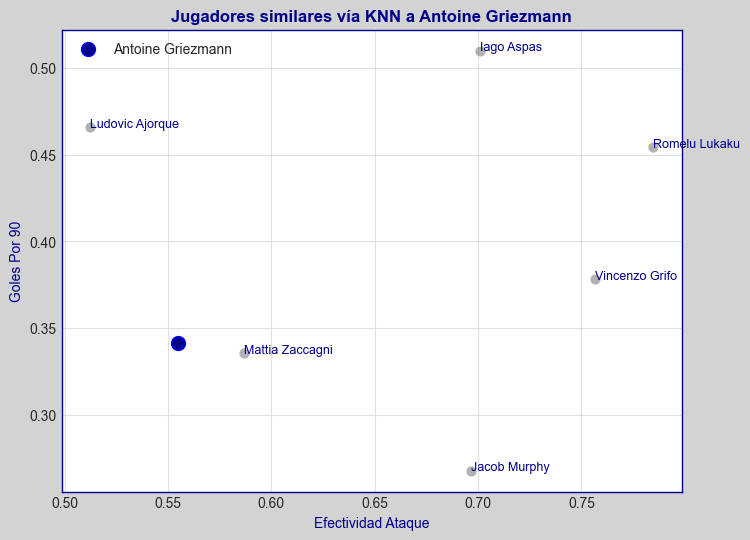


📊 El jugador pertenece al cluster 1

✅ Análisis completado en 0.47 segundos


In [19]:
# 6. DESPLIEGUE DEL SISTEMA
print("\n" + "🚀 DESPLIEGUE DEL SISTEMA DE RECOMENDACIÓN".center(80, "="))

# Mostrar jugadores disponibles
despliegue_modelo_similars()

# Analizar un jugador específico
recomendaciones_jug_atleti = despliegue_modelo_similars("Griezmann", top_n=6)

In [20]:
# Función atractiva para visualizar similar players
def visualizar_jugador_similares(jugador_nombre, similares, top_n=5):
    """
    Crea una visualización atractiva con la foto del jugador y sus similares
    
    Args:
        jugador_nombre: Nombre del jugador del Atlético
        similares: DataFrame con jugadores similares
        top_n: Número de jugadores similares a mostrar
    """
    
    # Obtener dorsal del jugador
    jugador_real = alias_mapping.get(jugador_nombre, jugador_nombre)
    
    # Ruta a la imagen y escudo. Está definida para Antonine Griezman, para otro jugador habría que cambiar los parámetros
    ruta_imagen = f"assets/players/{"Numero"}.png" if 'Numero' in locals() else f"assets/players/7.png"
    ruta_escudo = "assets/escudos/atm.png"
    
    # Verificar si existe la imagen
    if not os.path.exists(ruta_imagen):
        ruta_imagen = "assets/players/default.png"  # Imagen por defecto
    
    # Colores
    color_fondo = "#E5E5E5"  # Gris más claro
    color_texto = "#001F5C"  # Azul oscuro
    
    # Crear figura
    fig = plt.figure(figsize=(15, 8), facecolor=color_fondo)
    gs = gridspec.GridSpec(2, 6, width_ratios=[1.5, 1, 1, 1, 1, 1], height_ratios=[0.6, 3])
    
    # Título principal
    ax_title = plt.subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.6, 0.05, f"JUGADORES SIMILARES A {jugador_real.upper()}", 
                 ha='center', va='center', fontsize=30, fontweight='bold', color=color_texto)
    
    # Jugador principal
    ax_jugador = plt.subplot(gs[1, 0])
    ax_jugador.axis('off')
    
    # Cargar imagen
    img = plt.imread(ruta_imagen)
    ax_jugador.imshow(img)
    
    # Información del jugador
    info_jugador = df_atletico[df_atletico['Nombre'] == jugador_real].iloc[0] if jugador_real in df_atletico['Nombre'].values else None
    posicion = info_jugador['Posicion'] if info_jugador is not None and 'Posicion' in info_jugador else "FW"
    # Obtener edad desde df_general (donde están los datos correctos)
    if jugador_real in df_general['Nombre'].values:
        edad = df_general[df_general['Nombre'] == jugador_real]['Edad'].values[0]
    else:
        edad = info_jugador['Edad'] if info_jugador is not None and 'Edad' in info_jugador else "-"
    # Cargar escudo
    if os.path.exists(ruta_escudo):
        escudo = plt.imread(ruta_escudo)
        escudo_ax = fig.add_axes([-0.015, 0.68, 0.25, 0.25])  # [left, bottom, width, height]
        escudo_ax.imshow(escudo)
        escudo_ax.axis('off')
    
    # Añadir información básica (más abajo)
    ax_jugador.text(0.5, -0.15, f"{jugador_real}", transform=ax_jugador.transAxes,
                   ha='center', fontsize=16, fontweight='bold', color=color_texto)
    ax_jugador.text(0.5, -0.21, f"Edad: {edad}", transform=ax_jugador.transAxes,
                   ha='center', fontsize=12, color=color_texto)
    ax_jugador.text(0.5, -0.26, f"Posición: {posicion}", transform=ax_jugador.transAxes,
                   ha='center', fontsize=12, color=color_texto)
    
    # Top jugadores similares
    similares_top = similares.head(top_n).copy()
    
    # Imágenes de jugadores similares
    imagenes_jugadores = {
        "Ludovic Ajorque": "assets/players/ajorque.png",
        "Mattia Zaccagni": "assets/players/zacagni.png",
        "Iago Aspas": "assets/players/aspas.png",
        "Romelu Lukaku": "assets/players/lukaku.png",
        "Vincenzo Grifo": "assets/players/grifo.png"
    }
    
    for i, (_, jugador) in enumerate(similares_top.iterrows(), 1):
        ax_similar = plt.subplot(gs[1, i])
        ax_similar.axis('off')
        
        # Cuadro donde iría la foto
        rect = patches.Rectangle((0.045, 0.6), 0.95, 0.45, linewidth=1, 
                               edgecolor=color_texto, facecolor='white', alpha=0.8)
        ax_similar.add_patch(rect)
        
        # Información del jugador similar
        nombre = jugador['Nombre'] if 'Nombre' in jugador else f"Jugador {i}"
        equipo = jugador['Equipo'] if 'Equipo' in jugador else "-"
        distancia = jugador['distancia'] if 'distancia' in jugador else 0
        edad = jugador['Edad'] if 'Edad' in jugador else "-"
        contrato = jugador['Contrato'] if 'Contrato' in jugador else "-"
        valor = jugador['Valor'] if 'Valor' in jugador else "-"
        
        # Intentar cargar imagen del jugador si existe
        if nombre in imagenes_jugadores and os.path.exists(imagenes_jugadores[nombre]):
            img_jugador = plt.imread(imagenes_jugadores[nombre])
            img_box = ax_similar.inset_axes([0.1, 0.62, 0.8, 0.3], zorder=2)
            img_box.imshow(img_jugador)
            img_box.axis('off')
        
        img_box.imshow(img_jugador, aspect='auto')  # Añade aspect='auto'

        # Número y nombre (en azul, más destacado)
        ax_similar.text(0.1, 0.42, f"{i}. ", ha='right', va='center', 
                       fontsize=14, fontweight='bold', color=color_texto)
        ax_similar.text(0.15, 0.42, f"{nombre}", ha='left', va='center', 
                       fontsize=14, fontweight='bold', color=color_texto)
        
        # Resto de información
        ax_similar.text(0.15, 0.32, f"{equipo}", ha='left', va='center', 
                       fontsize=12, color=color_texto)
        ax_similar.text(0.15, 0.24, f"Distancia: {distancia:.2f}", ha='left', va='center', 
                       fontsize=11, color=color_texto)
        ax_similar.text(0.15, 0.16, f"Edad: {edad}", ha='left', va='center', 
                       fontsize=11, color=color_texto)
        ax_similar.text(0.15, 0.08, f"Contrato: {contrato}", ha='left', va='center', 
                       fontsize=11, color=color_texto)
        ax_similar.text(0.15, 0.0, f"Valor: {valor}", ha='left', va='center', 
                       fontsize=11, color=color_texto)
        
        # Añadir línea separadora
        ax_similar.axhline(y=-0.1, color=color_texto, linestyle='-', xmin=0.05, xmax=0.95, alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.3)   
        
    return fig

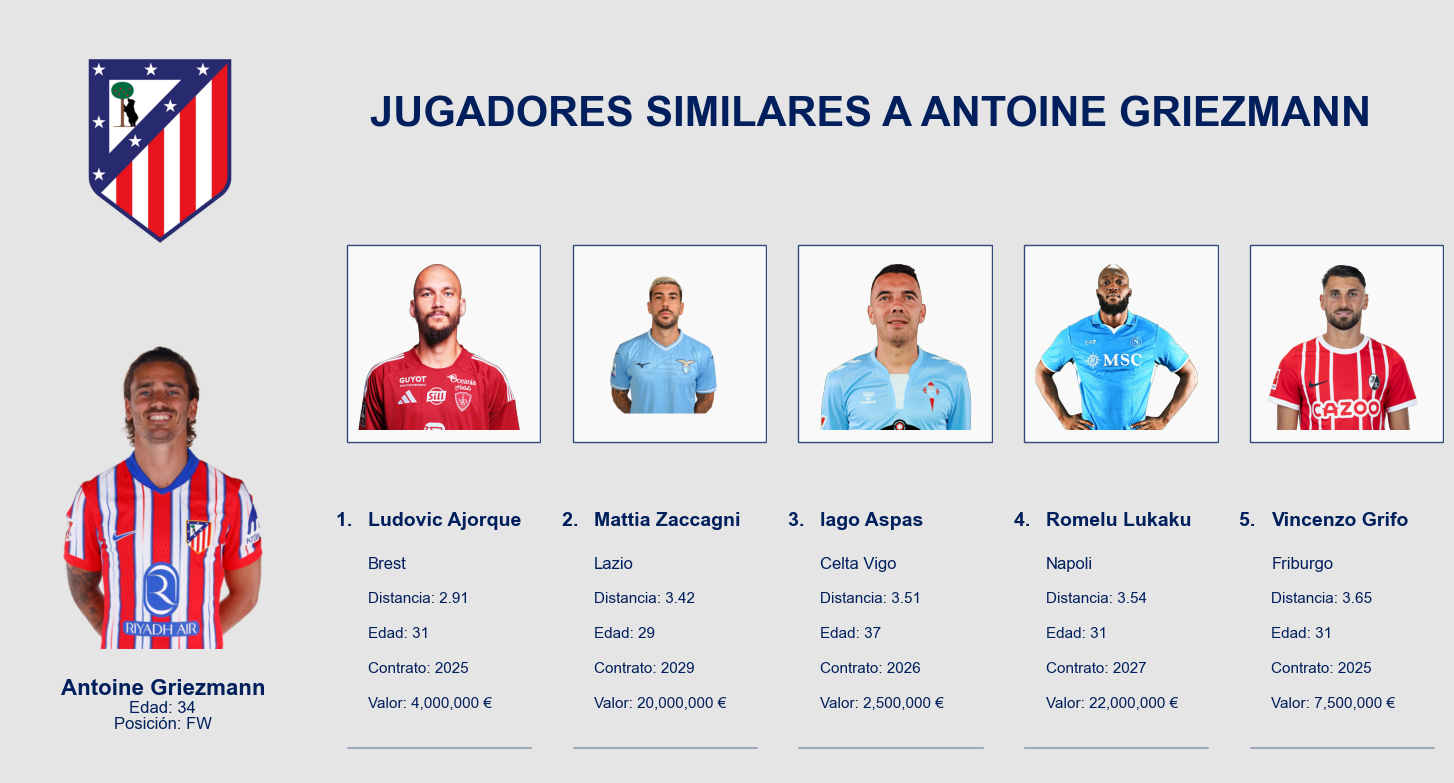

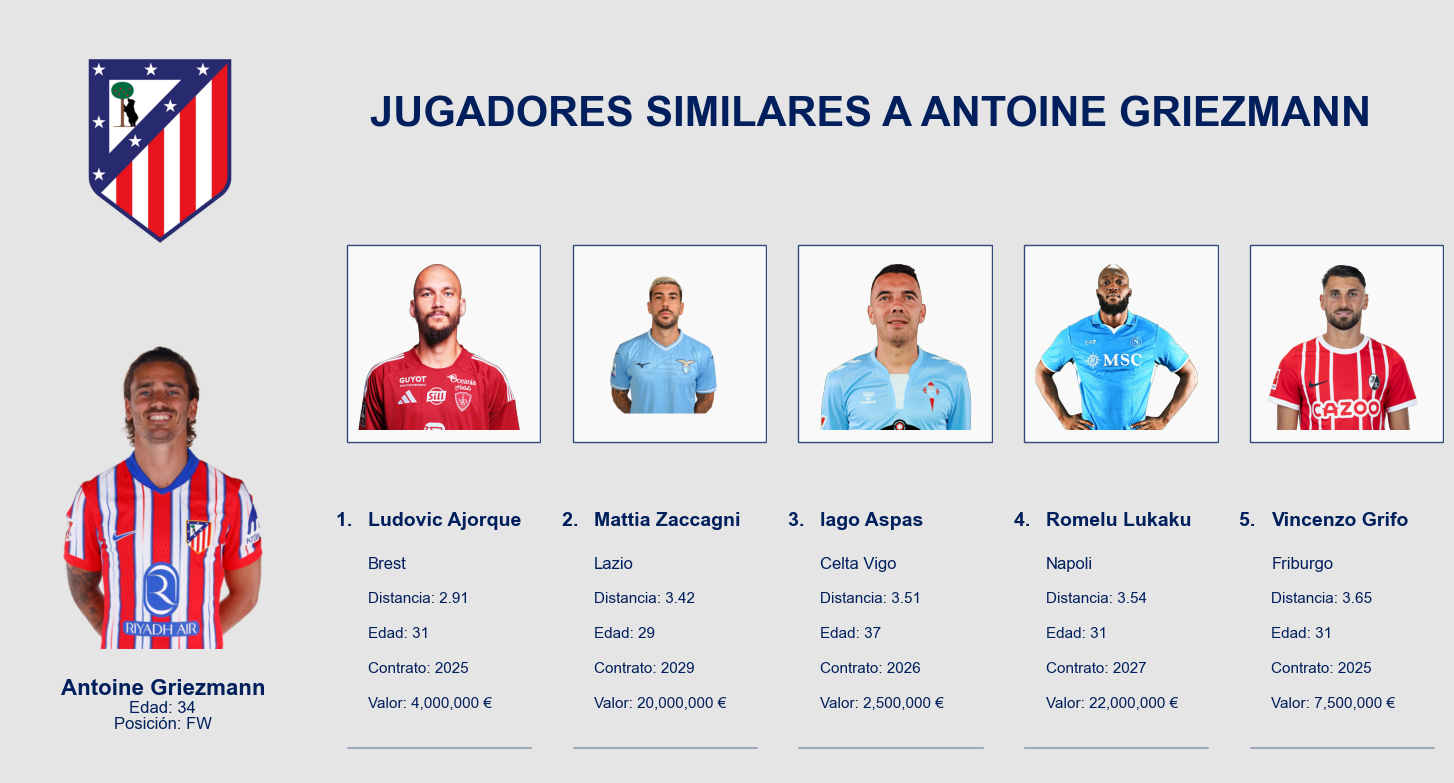

In [21]:
# Fucnión visualización sistema_recomendacion_jugadores
visualizar_jugador_similares(jugador_real, recomendaciones_jug_atleti, top_n=5)

## 6.2 Documentación de Uso

El sistema de recomendación de jugadores similares está diseñado para ayudar a la dirección deportiva y al cuerpo técnico del Atlético de Madrid a identificar futbolistas con características estadísticas similares a los de su plantilla actual.

### <u>Cómo usar los modelos</u>

1. Búsqueda básica de jugadores similares:
- Para ver jugadores disponibles:

_despliegue_modelo_similars()_

- Para analizar un jugador específico:

_recomendaciones = despliegue_modelo_similars("Griezmann", top_n=5)_

2. Análisis detallado por posición:
- Evaluar clusters de una posición

_evaluar_clustering(resultado_clusters, df_por_posicion, posicion="FW")_

- Comparar varios jugadores:

_evaluar_knn(["Griezmann", "Oblak", "Koke"], resultado_clusters, df_atletico, df_general, df_porteros, df_mercado, df_equipos)_

3. Actualizar datos:
- Proporcionar nuevos dataframes para actualizar el sistema

_nuevos_datos = {
    'general': df_general_nuevo,
    'porteros': df_porteros_nuevo,
    'mercado': df_mercado_nuevo
}
despliegue_modelo_similars("Griezmann", datos_nuevos=nuevos_datos)_

### <u>Requerimientos</u>

1. Python 3.7+

2. Bibliotecas: pandas, numpy, scikit-learn, matplotlib, seaborn.

3. Estructura de archivos:

_/assets/players/: Imágenes de los jugadores (formato: {dorsal}.png)_

_/assets/escudos/: Escudos de equipos (incluye atm.png)_

### <u>Limitaciones</u>

1. Calidad de datos: 
- La precisión de las recomendaciones depende directamente de la calidad y completitud de los datos de entrada.

2. Factores no cuantificables: 
- El sistema no puede capturar aspectos intangibles como la actitud, inteligencia táctica o capacidad de liderazgo.

3. Temporalidad: 
- Las recomendaciones se basan en datos históricos que pueden no reflejar el rendimiento actual o futuro.

4. Sesgo contextual: 
- Las estadísticas de los jugadores están influenciadas por el sistema táctico de sus equipos, compañeros, ligas, etc.

5. Jugadores emergentes: 
El sistema puede no identificar adecuadamente a jugadores jóvenes con pocos minutos pero gran potencial.

### <u>Mantenimiento necesario</u>

1. Actualización periódica de datos: 
- Se recomienda actualizar los datos estadísticos al menos mensualmente, pero lo ideal tras cada disputa de una jornada.

2. Revisión de parámetros: 
- Los parámetros del modelo (número de clusters, características seleccionadas) deben revisarse semestralmente, al menos.

3. Validación de recomendaciones: 
- Las recomendaciones deben validarse con el departamento en el que se implemente para refinar el modelo.

4. Monitoreo de nuevos jugadores: 
- Incorporar datos de jugadores emergentes regularmente.

5. Backup de modelos: 
- Mantener versiones de modelos entrenados para comparar evolución y rendimiento.

# 7. Conclusiones y Recomendaciones

### <u>Resultados principales</u>

1. Clasificación por posiciones: 
- El análisis de clustering K-Means ha identificado perfiles de juego distintivos dentro de cada posición, revelando agrupaciones naturales basadas en características estadísticas.

2. Efectividad del KNN: 
-El algoritmo KNN ha demostrado ser eficaz para identificar jugadores similares, con distancias medias que sugieren un alto grado de similitud para la mayoría de los jugadores de la plantilla.

3. Perfiles únicos: 
- Algunos jugadores como Griezmann muestran perfiles estadísticos que los sitúan en clusters pequeños y exclusivos, indicando características más difíciles de reemplazar.

4. Optimización por posición: 
- Los resultados muestran que diferentes características tienen importancia variada según la posición, validando el enfoque de análisis segmentado.

### <u>Interpretación deportiva</u>

1. Reemplazo de jugadores: 
- El sistema proporciona alternativas viables para cada perfil de jugador, facilitando la planificación de fichajes ante posibles salidas.

2. Diversificación táctica: 
- Los clusters identificados permiten analizar qué perfiles de jugadores podrían complementar mejor el estilo de juego actual.

3. Análisis de competidores: 
- El modelo identifica jugadores similares en equipos rivales, lo que puede informar estrategias tácticas específicas.

4. Valoración de mercado: 
- La comparación entre jugadores similares ayuda a evaluar si los valores de mercado son acordes a sus perfiles estadísticos.

### <u>Limitaciones encontradas</u>

1. Profundidad de datos: 
- Faltan algunas métricas avanzadas relacionadas con el trabajo condicional, además de que se debe entrenar y perfeccionar continuamente.

2. Contextualización: 
-El modelo no considera adecuadamente el contexto táctico o la calidad de los equipos donde juegan los futbolistas, y es un punto a tener en cuenta.

3. Aspectos fuera de juego: 
- No se consideran factores como adaptabilidad cultural, historial médico o aspectos de comportamiento. Esto lleva trabajo de reclutamiento mayor de datos y asignación de valores.

4. Sesgo hacia estadísticas acumulativas: 
- Jugadores con más minutos pueden estar sobrerrepresentados en algunas métricas.

### <u>Mejoras propuestas</u>

1. <u>Incorporación de datos de tracking:</u> Añadir métricas de GPS/seguimiento para evaluar aspectos físicos y posicionales.

2. <u>Análisis de video:</u> Complementar con evaluaciones cualitativas basadas en análisis de video.

3. <u>Ponderación contextual:</u> Desarrollar factores de ajuste según la dificultad de las ligas y roles tácticos.

4. <u>Análisis temporal:</u> Incorporar la evolución de rendimiento en el tiempo para detectar tendencias.

5. <u>Interfaz web interactiva:</u> Desarrollar una plataforma web para que los usuarios no técnicos puedan explorar recomendaciones.

### <u>Aplicaciones prácticas</u>

1. <u>Planificación de mercado:</u> Identificar objetivos de fichaje alineados con perfiles específicos.

2. <u>Preparación de partidos:</u> Analizar jugadores rivales comparándolos con perfiles conocidos.

3. <u>Desarrollo de cantera:</u> Evaluar a qué jugadores profesionales se asemejan los jóvenes talentos.

4. <u>Negociaciones contractuales:</u> Valorar jugadores comparándolos con perfiles similares en el mercado.

5. <u>Estrategia a largo plazo:</u> Identificar tendencias en perfiles de jugadores para anticipar evolución táctica.

**El sistema proporciona una base sólida para la toma de decisiones basada en datos, complementando (no reemplazando) el conocimiento experto de los profesionales del club de fútbol en el que se instaure.**

# Función Ejecución Script completo

if __name__ == "__main__":
    # Ejecución principal
    print("Iniciando análisis...")

In [ ]:
def ejecutar_analisis_completo():
    """
    Función principal que ejecuta todo el flujo de análisis de jugadores similares.
    """

    print("\n" + "🚀 ANÁLISIS DE JUGADORES SIMILARES - ATLÉTICO DE MADRID".center(80, "="))
    
    inicio = time.time()
    
    # 1. Limpieza de datos
    print("\n📋 Fase 1: Limpieza y preparación de datos")
    limpiar_datos(df_general, df_porteros, df_mercado, df_atletico, df_equipos, df_master_equipos)
    
    # 2. Ingeniería de características
    print("\n⚙️ Fase 2: Creación de características por posición")
    df_por_posicion = crear_features(df_general, df_porteros, df_equipos, df_mercado)
    print(f"✓ Características creadas para {sum(1 for df in df_por_posicion.values() if not df.empty)} posiciones")
    
    # 3. Clustering mediante K-Means
    print("\n🔍 Fase 3: Aplicación de algoritmos de clustering")
    resultado_clusters = preparar_datos_modelado(df_por_posicion)
    print("✓ Clustering K-Means completado")
    
    # 4. Evaluación de los modelos
    print("\n📊 Fase 4: Evaluación de modelos")
    evaluation_results = evaluar_clustering(resultado_clusters, df_por_posicion)
    print("✓ Evaluación de clustering completada")
    
    # 5. Análisis de jugadores específicos
    print("\n👥 Fase 5: Análisis de jugadores específicos")
    
    # Lista de jugadores destacados por posición
    jugadores_destacados = {
        "GK": ["Oblak"],
        "DF": ["Gimenez", "Le Normand"],
        "MF": ["Koke", "De Paul", "Barrios"],
        "FW": ["Griezmann", "Julian Alvarez"]
    }
    
    # Analizar un jugador por posición
    for posicion, jugadores in jugadores_destacados.items():
        if jugadores:
            print(f"\n📌 Analizando un {posicion}: {jugadores[0]}")
            try:
                recomendaciones = entrenar_modelo_knn(
                    jugadores[0], 
                    resultado_clusters, 
                    df_atletico, 
                    df_general, 
                    df_porteros, 
                    df_mercado, 
                    df_equipos,
                    top_n=5,
                    graficar=False
                )
                
                # Visualización mejorada
                visualizar_jugador_similares(jugadores[0], recomendaciones, top_n=5)
                
            except Exception as e:
                print(f"⚠️ Error al analizar {jugadores[0]}: {e}")
    
    # 6. Tiempo total de ejecución
    tiempo_total = time.time() - inicio
    print(f"\n✅ Análisis completo finalizado en {tiempo_total:.2f} segundos")
    
    return {
        "df_por_posicion": df_por_posicion,
        "resultado_clusters": resultado_clusters,
        "evaluation_results": evaluation_results
    }

# Ejecución principal
if __name__ == "__main__":
    resultados = ejecutar_analisis_completo()
    print("\nPuedes acceder a los resultados a través de la variable 'resultados'")